In [1]:
import pybedtools as pbt
import pysam
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import scipy.stats as ss
from sklearn.linear_model import LinearRegression
import csv
from keras.models import load_model
from pkg_resources import resource_filename
from spliceai.utils import one_hot_encode
from maxentpy import maxent
from collections import Counter
import itertools
import matplotlib

Using TensorFlow backend.


In [2]:
import altair as alt
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [3]:
import os.path as op

In [4]:
import seaborn as sns

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import splanl.junction_scorer as jn
import splanl.merge_bcs as mbcs
import splanl.coords as cds
import splanl.plots as sp
import splanl.score_motifs as sm
import splanl.inspect_variants as iv
import splanl.post_processing as pp
import splanl.custom_splai_scores as css
import splanl.create_vcf as vcf

In [7]:
matplotlib.rc_file_defaults()
plt.rcParams[ 'pdf.fonttype' ] = 42
plt.rcParams[ 'ps.fonttype' ] = 42
plt.rcParams[ 'font.sans-serif' ] = "Arial"
plt.rcParams[ 'font.family' ] = "sans-serif"

In [8]:
chr11 = '/nfs/kitzman3/lab_common/refs/human/ucsc_hg19/bychrom/chr11.fa'
chr11_seq = pp.get_refseq( chr11 )[ 0 ]

In [9]:
fa_file = '/nfs/kitzman2/jacob/proj/jensplice/20220415_wt1_mpsa_trial3/jkp1053_1054_1055.fa'
refseq = pp.get_refseq( fa_file )[ 0 ]

In [10]:
github_colors = '3182bd6baed69ecae1c6dbefe6550dfd8d3cfdae6bfdd0a231a35474c476a1d99bc7e9c0756bb19e9ac8bcbddcdadaeb636363969696bdbdbdd9d9d9'

In [11]:
light_colors = [ '#' + github_colors[i:i+6] for i in range( 0, len( github_colors ), 6 ) ]

In [12]:
tab20 = cm.get_cmap('tab20c' )
new_tab = [ tab20( i ) for i in range( 0, 16, 4 ) ] 
tab_sdv = ListedColormap( new_tab )
new_tab = [ tab20( i ) for i in range( 2, 18, 4 ) ] 
tab_intmed = ListedColormap( new_tab )

In [13]:
plot_out = '/nfs/kitzman2/smithcat/proj/wt1_2022/plots/'

In [14]:
bdout = '/nfs/kitzman2/smithcat/proj/wt1_2022/ex9_data/'

In [15]:
byvartbl_long = pd.read_table( bdout + 'wt1_ex9_by_var_effects_snvs-2022-0721.txt' )

In [16]:
byvartbl_wide = pd.read_table( bdout + 'wt1_ex9_by_var_effects_snvs_wide-2022-0727b.txt' )

In [17]:
byvartbl_wide = mbcs.create_variables_across_samples( byvartbl_wide,
                                                 [ samp for samp in byvartbl_long[ 'sample' ].unique() ],
                                                 mean_cols = [ 'n_bc','n_bc_passfilt', 'sum_reads','sum_reads_passfilt', ],
                                                 median_cols = [ 'n_bc','n_bc_passfilt', 'sum_reads','sum_reads_passfilt', ],
                                                 sum_cols = [ 'sum_reads','sum_reads_passfilt', ],
                                                 max_cols = [ 'n_bc','n_bc_passfilt', 'sum_reads','sum_reads_passfilt', ] )

In [18]:
byvartbl_wide = mbcs.compute_bc_weighted_psi( byvartbl_wide,
                                         [ samp for samp in byvartbl_long[ 'sample' ].unique() ],
                                         [ 'KTS+','KTS-','SKIP','OTHER' ],
                                         'n_bc_passfilt',
                              )

In [19]:
for col in [ 'wmean_KTS+', 'wmean_KTS-', 'wmean_SKIP', 'wmean_OTHER', 'DS_maxm', 'ss_don_prob_32413527', 'ss_don_prob_32413518', 'bp_wt_prob', 'DBP_max', ]:
    
    byvartbl_wide[ col + '_100' ] = byvartbl_wide[ col ]*100

In [156]:
maxent_wt = pd.read_table( '/nfs/kitzman2/smithcat/proj/spliceAI/maxent_scores/wt1_ex9_wt_ss_probs.txt' ).rename( columns = { 'pos': 'hg19_pos',  
                                                                                                                              'wt_acc_pr': 'maxent_wt_acc', 
                                                                                                                              'wt_don_pr': 'maxent_wt_don' } )

In [157]:
byvartbl_wide = byvartbl_wide.drop( columns = [ 'maxent_wt_acc', 'maxent_wt_don' ] )

In [159]:
byvartbl_wide = byvartbl_wide.set_index( [ 'hg19_pos', 'ref' ] ).merge( maxent_wt.set_index( [ 'hg19_pos', 'ref' ] ),
                                                                   how = 'left',
                                                                   left_index = True,
                                                                   right_index = True ).reset_index()

In [162]:
byvartbl_wide_sat = pp.saturate_variants( byvartbl_wide,
                                         chr11_seq,
                                         'hg19_pos',
                                          'exon_num',
                                          rev_strand = True )[ 9 ]

In [163]:
#plots get messed up without the vector position included
byvartbl_wide_sat[ 'pos' ] = byvartbl_wide_sat.hg19_pos - 32412079 - 2*( byvartbl_wide_sat.hg19_pos - byvartbl_wide_sat.hg19_pos.min() )

In [164]:
byvartbl_wide_sat[ 'hgvs_pos' ] = cds.pos_to_hgvspos( byvartbl_wide_sat.pos,
                                                     ( 1058, 1554 ),
                                                    [ (1267, 1359) ],
                                                    [ ( 1355, 1447 ), ]
                                                    )

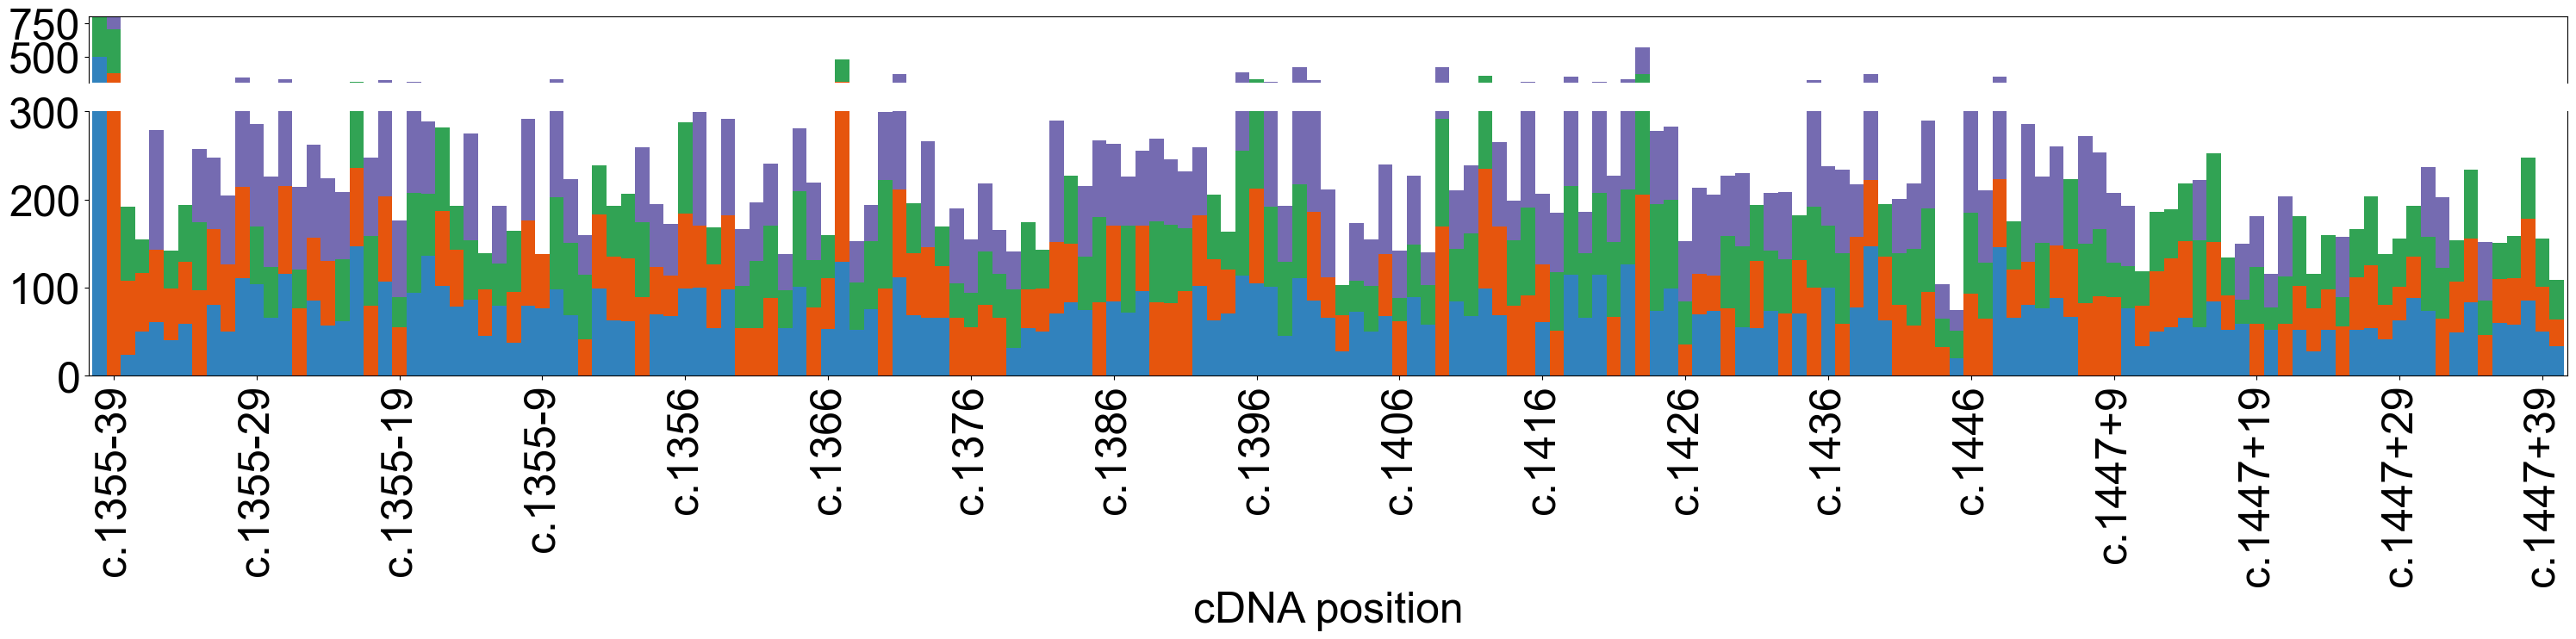

In [23]:
sp.split_ax_bcs(  byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                  [ 'n_bc_passfilt_mean' ],
                  'hgvs_pos',
                    [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                    [ ( 300.5, 800 ), ( 0, 300 ) ],
                    fig_size = ( 30, 7.5 ),
                    legend = False,
                    hratios = [ 1, 4 ],
                    x_ax_title = 'cDNA position',
                    #tight = False,
                    #savefile = plot_out + 'bcs_filt_by_pos_split.pdf'
                           )

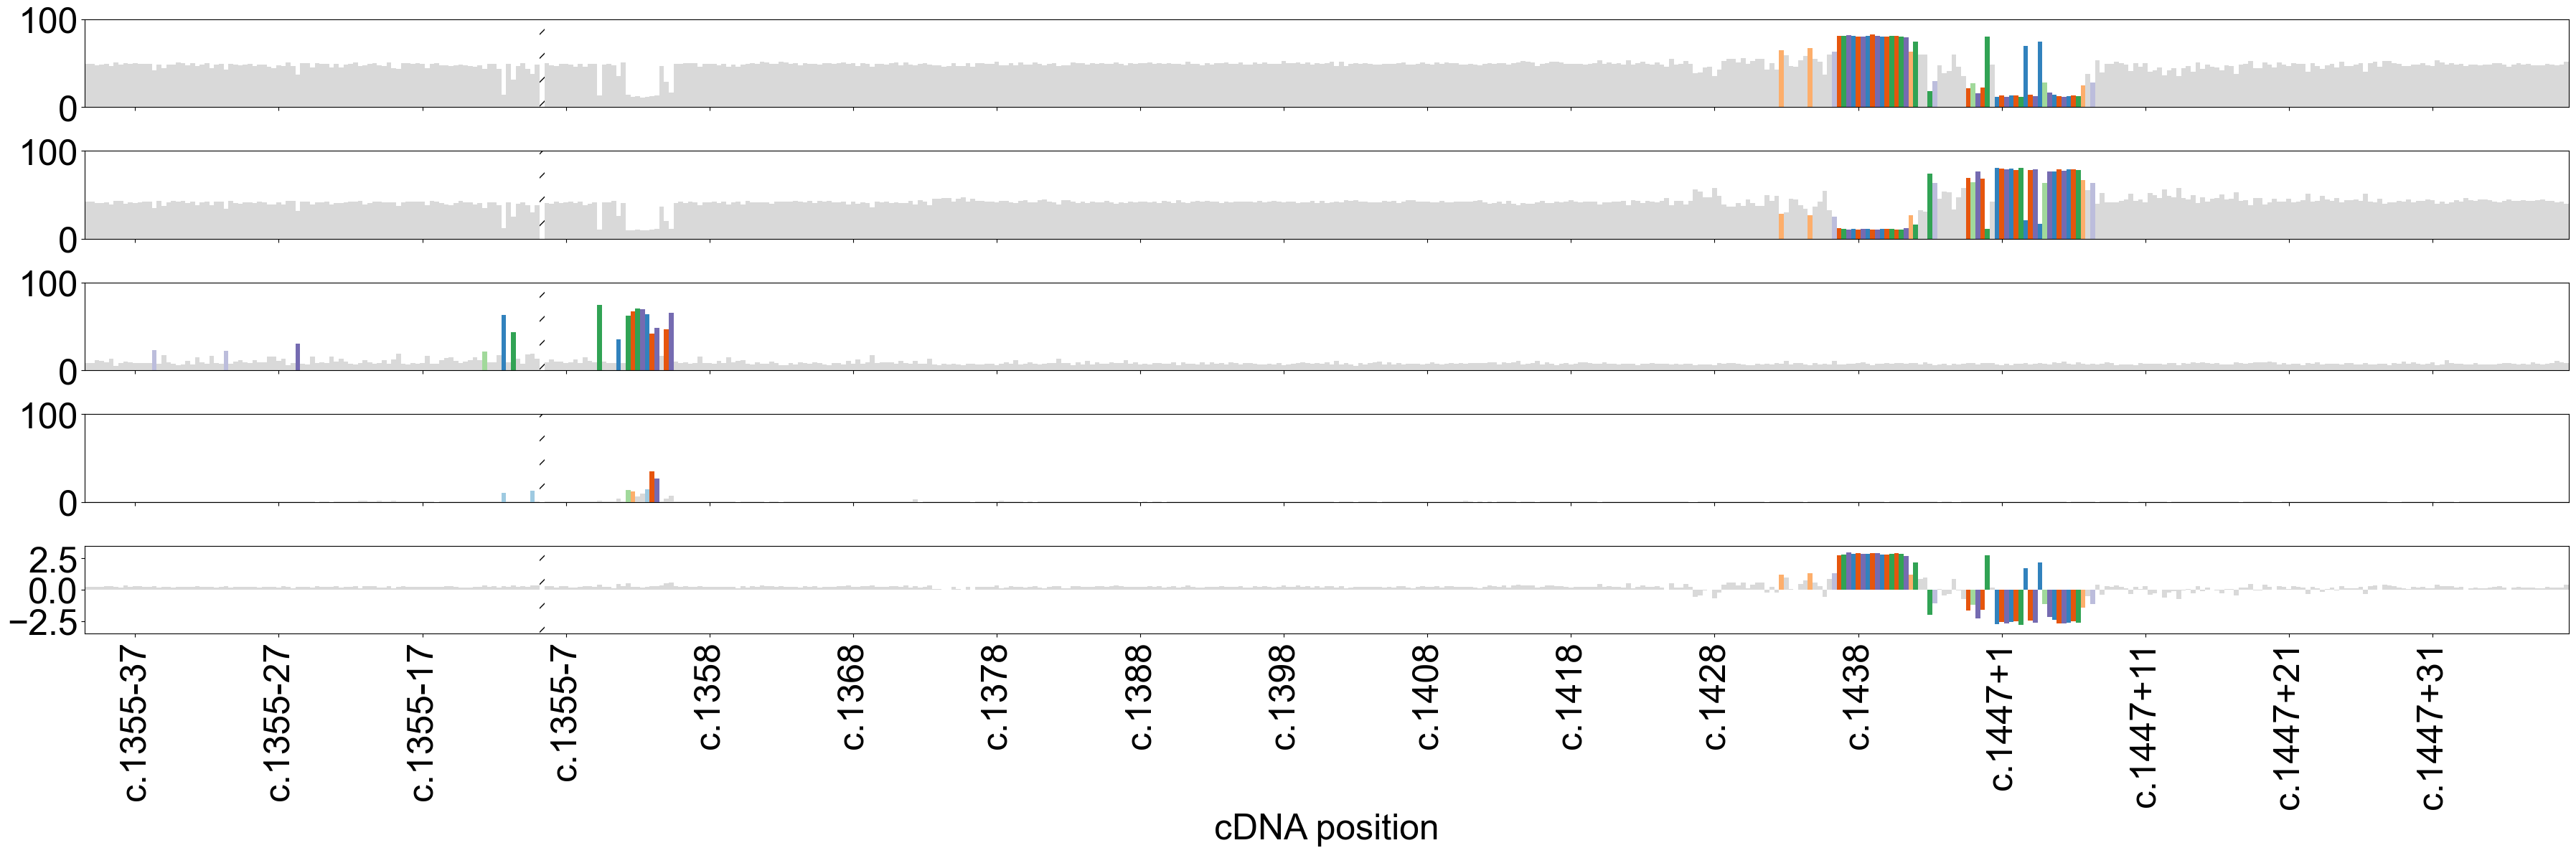

In [131]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                         [ 'wmean_KTS+_100', 'wmean_KTS-_100', 'wmean_SKIP_100', 'wmean_OTHER_100', 'KTS_+_ratio_log2' ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 36, 12 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'intmed_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                          darken_bars2 = [ ( 'sdv_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 100 ), ( 0, 100 ), ( 0, 100 ), ( 0, 100 ), ( -3.5, 3.5 ) ],
                          y_ax_title = [ '', '', '', '', '' ], 
                          x_ax_title = 'cDNA position',
                          tick_spacing = 10,
                          #hatch_missing = [ ( 'wmean_SKIP_100', '/' ) ],
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

In [25]:
byvartbl_wide.loc[ byvartbl_wide.lit_interp.isnull(), 'lit_interp' ] = ''

In [26]:
lit_marker_d = { '': 'o',
                 'Likely benign/benign': 's',
                 'Likely pathogenic/pathogenic (ClinVar)': '^',
                 'Likely pathogenic/pathogenic (Literature)': 'v',
                 'VUS/Conflicting': 'd' }

In [27]:
#now in plots!
def scatter_by_sdv_alt_interp( tbl_by_var,
                               interp_col,
                               x_col,
                               y_col,
                               cmap,
                               marker_by_interp,
                               alt_col = 'alt',
                               sdv_col = 'sdv',
                               intmed_col = None,
                               intmed_cmap = None,
                               null_color = '.85',
                               marker_size = 5,
                               xlabel = '',
                               ylabel = '',
                               xlim = None,
                               ylim = None,
                               savefig = None ):
    
    tbv = tbl_by_var.copy()
    
    #we want the SDV variants on top so loop through twice for maximum control
    for interp in tbv[ interp_col ].unique():
    
        lit_null = tbv.loc[ ~( tbv[ sdv_col ] ) & ( tbv[ interp_col ] == interp ) ].copy()
    
        if len( lit_null ) > 0:
        
            plt.scatter( lit_null[ x_col ],
                         lit_null[ y_col ],
                         marker = marker_by_interp[ interp ],
                         c = null_color,
                         s = marker_size )
            
    if intmed_col:
        
        for interp in tbv[ interp_col ].unique():
    
            lit_intmed = tbv.loc[ ( tbv[ intmed_col ] ) & ( tbv[ interp_col ] == interp ) ].copy()
    
            if len( lit_intmed ) > 0:
        
                plt.scatter( lit_intmed[ x_col ],
                             lit_intmed[ y_col ],
                             marker = marker_by_interp[ interp ],
                             c = [ 0 if a.upper() == 'A' \
                                   else 1 if a.upper() == 'C' \
                                   else 2 if a.upper() == 'G' \
                                   else 3 for a in lit_intmed[ alt_col ] ],
                             cmap = intmed_cmap,
                             s = 2*marker_size )
            
    for interp in tbv[ interp_col ].unique():
    
        lit_sdv = tbv.loc[ ( tbv[ sdv_col ] ) & ( tbv[ interp_col ] == interp ) ].copy()
    
        if len( lit_sdv ) > 0:
        
            plt.scatter( lit_sdv[ x_col ],
                         lit_sdv[ y_col ],
                         marker = marker_by_interp[ interp ],
                         c = [ 0 if a.upper() == 'A' \
                               else 1 if a.upper() == 'C' \
                               else 2 if a.upper() == 'G' \
                               else 3 for a in lit_sdv[ alt_col ] ],
                         cmap = cmap,
                         s = 2*marker_size )
            
    plt.xlabel( xlabel )
    plt.ylabel( ylabel )
    
    if xlim:
        plt.xlim( xlim )
    if ylim:
        plt.ylim( ylim )
        
    if savefig:
        plt.savefig( savefig,
                     dpi = 300,
                     bbox_inches = 'tight' )
        
    plt.show()

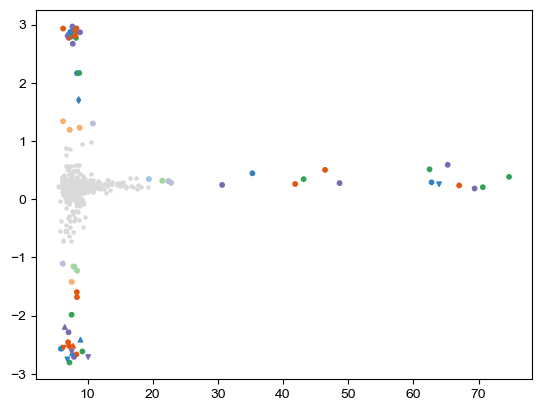

In [28]:
scatter_by_sdv_alt_interp( byvartbl_wide,
                           'lit_interp',
                           'wmean_SKIP_100',
                           'KTS_+_ratio_log2',
                            tab_sdv,
                            lit_marker_d,
                            alt_col = 'alt_c',
                            intmed_col = 'intmed',
                            intmed_cmap = tab_intmed,
                            marker_size = 5 )

In [110]:
#now in plots!
def scatter_by_interp( tbl_by_var,
                               interp_col,
                               x_col,
                               y_col,
                               marker_by_interp,
                               cmap,
                               null_color = '.85',
                               marker_size = 5,
                               xlabel = '',
                               ylabel = '',
                               xlim = None,
                               ylim = None,
                               savefig = None ):
    
    tbv = tbl_by_var.copy()
    
    lit_null = tbv.loc[ ( tbv[ interp_col ].isnull() ) | ( tbv[ interp_col ] == '' ) ].copy()
    
    if len( lit_null ) > 0:
        
        plt.scatter( lit_null[ x_col ],
                     lit_null[ y_col ],
                     marker = marker_by_interp[ '' ],
                     c = null_color,
                     s = marker_size )
    
    #we want the lit variants on top so plot these second for maximum control
    for i,interp in enumerate( tbv[ interp_col ].unique() ):
        
        #I want to allow the interp to be null here instead of just '' but its so difficult w strings
        if interp == '':
            continue
    
        lit_interp = tbv.loc[ ( tbv[ interp_col ] == interp ) ].copy()
    
        if len( lit_interp ) > 0:
        
            plt.scatter( lit_interp[ x_col ],
                         lit_interp[ y_col ],
                         marker = marker_by_interp[ interp ],
                         color = cmap( i - 1 ),
                         s = 2*marker_size )
            
    plt.xlabel( xlabel )
    plt.ylabel( ylabel )
    
    if xlim:
        plt.xlim( xlim )
    if ylim:
        plt.ylim( ylim )
        
    if savefig:
        plt.savefig( savefig,
                     dpi = 300,
                     bbox_inches = 'tight' )
        
    plt.show()

In [96]:
lit_marker_d

{'': 'o',
 'Likely benign/benign': 's',
 'Likely pathogenic/pathogenic (ClinVar)': '^',
 'Likely pathogenic/pathogenic (Literature)': 'v',
 'VUS/Conflicting': 'd'}

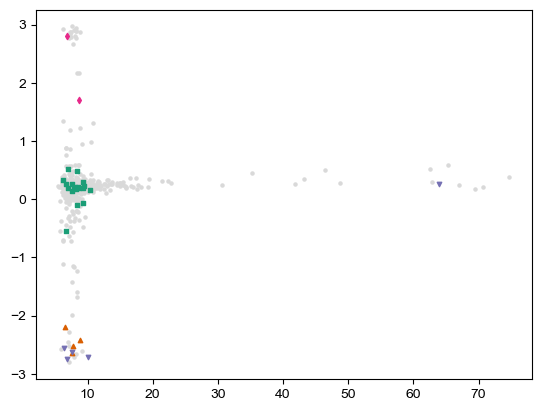

In [111]:
scatter_by_interp( byvartbl_wide,
                  'lit_interp',
                   'wmean_SKIP_100',
                   'KTS_+_ratio_log2',
                    lit_marker_d,
                    cm.get_cmap( 'Dark2' ),
                    marker_size = 5 )

In [144]:
maxent_wt

,pos,ref,maxent_wt_acc,maxent_wt_don
0,32413743,T,-22.823742,-11.832743
1,32413742,C,-12.366385,-6.317216
2,32413741,C,-5.226629,7.132257
3,32413740,C,-10.996631,-10.854251
4,32413739,A,-33.979872,-24.456697
...,...,...,...,...
261,32413482,A,-10.467633,-26.495939
262,32413481,A,-2.945257,-33.646718
263,32413480,A,-13.045413,-36.490198
264,32413479,A,-9.086820,-31.988088


In [29]:
acc_plot = [ 'wmean_SKIP_100', 'wmean_OTHER_100', 'maxent_acc', 'DS_maxm_100' ]

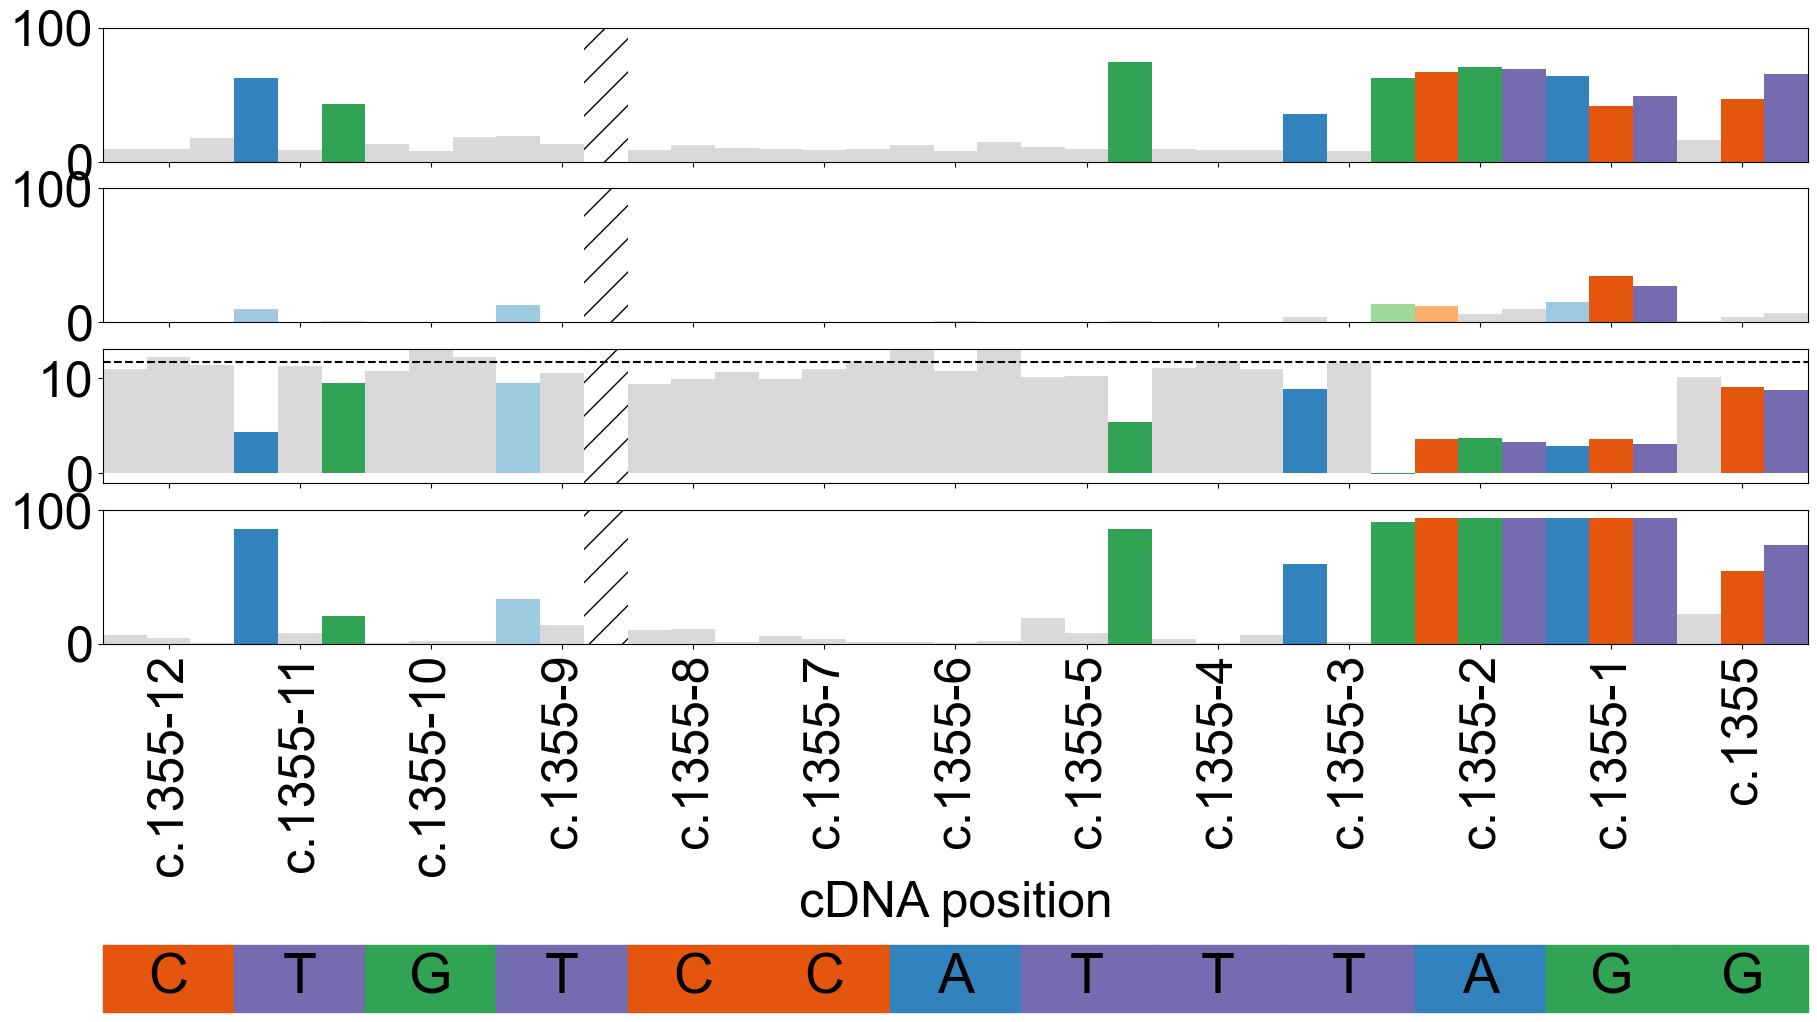

In [168]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                          acc_plot,
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          zoom = ( 1255, 1267 ),
                          fig_size = ( 22, 8 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ), ],
                          darken_bars2 = [ ( 'sdv_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ), ],
                          y_ax_lim = [ ( 0, 100 ), ( 0, 100 ), ( -1, 13 ), ( 0, 100 ), ],
                          y_ax_title = [ '' ]*len( acc_plot ),
                          x_ax_title = 'cDNA position',
                          tick_spacing = 1,
                          ref_labels = True,
                          y_ref_cds = -275,
                          colors_ref = [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                          tight = False,
                          hatch_missing = [ ( 'wmean_SKIP_100', '/' ) ],
                          hlines = [ None,
                                     None,
                                     ( byvartbl_wide_sat.loc[ byvartbl_wide_sat.pos == 1267 ].maxent_wt_acc.mean(), 'black', '--' ),
                                     None,
                                     ],
                          #savefile = plot_out + 'acc_zoom.pdf'
                     )

In [31]:
byvartbl_wide.loc[ ( byvartbl_wide.pos >= 1255 ) & ( byvartbl_wide.pos <= 1267 ) & ( byvartbl_wide.lit_interp != '' ) ]

,hgvs_pos,hg19_pos,ref,alt,ref_c,alt_c,pos,chrom,varlist,exon_num,...,KTS_+_ratio_log2,wmean_KTS+_100,wmean_KTS-_100,wmean_SKIP_100,wmean_OTHER_100,DS_maxm_100,ss_don_prob_32413527_100,ss_don_prob_32413518_100,bp_wt_prob_100,DBP_max_100
399,c.1355-1,32413611,C,T,G,A,1266,11,jkp815:1266:G:A,9,...,0.256781,11.508028,9.631679,63.932414,14.904771,94.007826,67.206919,45.648423,NaN,7.010762
419,c.1355-7,32413617,G,A,C,T,1260,11,jkp815:1260:C:T,9,...,0.198550,48.414564,42.189714,9.373850,0.353039,0.957894,97.929823,85.509539,NaN,0.000000
422,c.1355-8,32413618,G,A,C,T,1259,11,jkp815:1259:C:T,9,...,0.149580,47.023191,42.392007,10.417028,0.389861,1.354656,97.527581,85.579175,NaN,0.000000
426,c.1355-10,32413620,C,G,G,C,1257,11,jkp815:1257:G:C,9,...,0.267248,50.377054,41.858434,7.605339,0.414703,1.989269,98.961198,92.972058,NaN,0.000000


In [32]:
byvartbl_wide.loc[ ( byvartbl_wide.pos <= 1280 ) ].sdv.sum()

14

In [33]:
kts_neg_plot = [ 'wmean_KTS+_100', 'wmean_KTS-_100', 'KTS_+_ratio_log2', 'maxent_KTS-', 'DS_maxm_100', 'ss_don_prob_32413527_100', ]

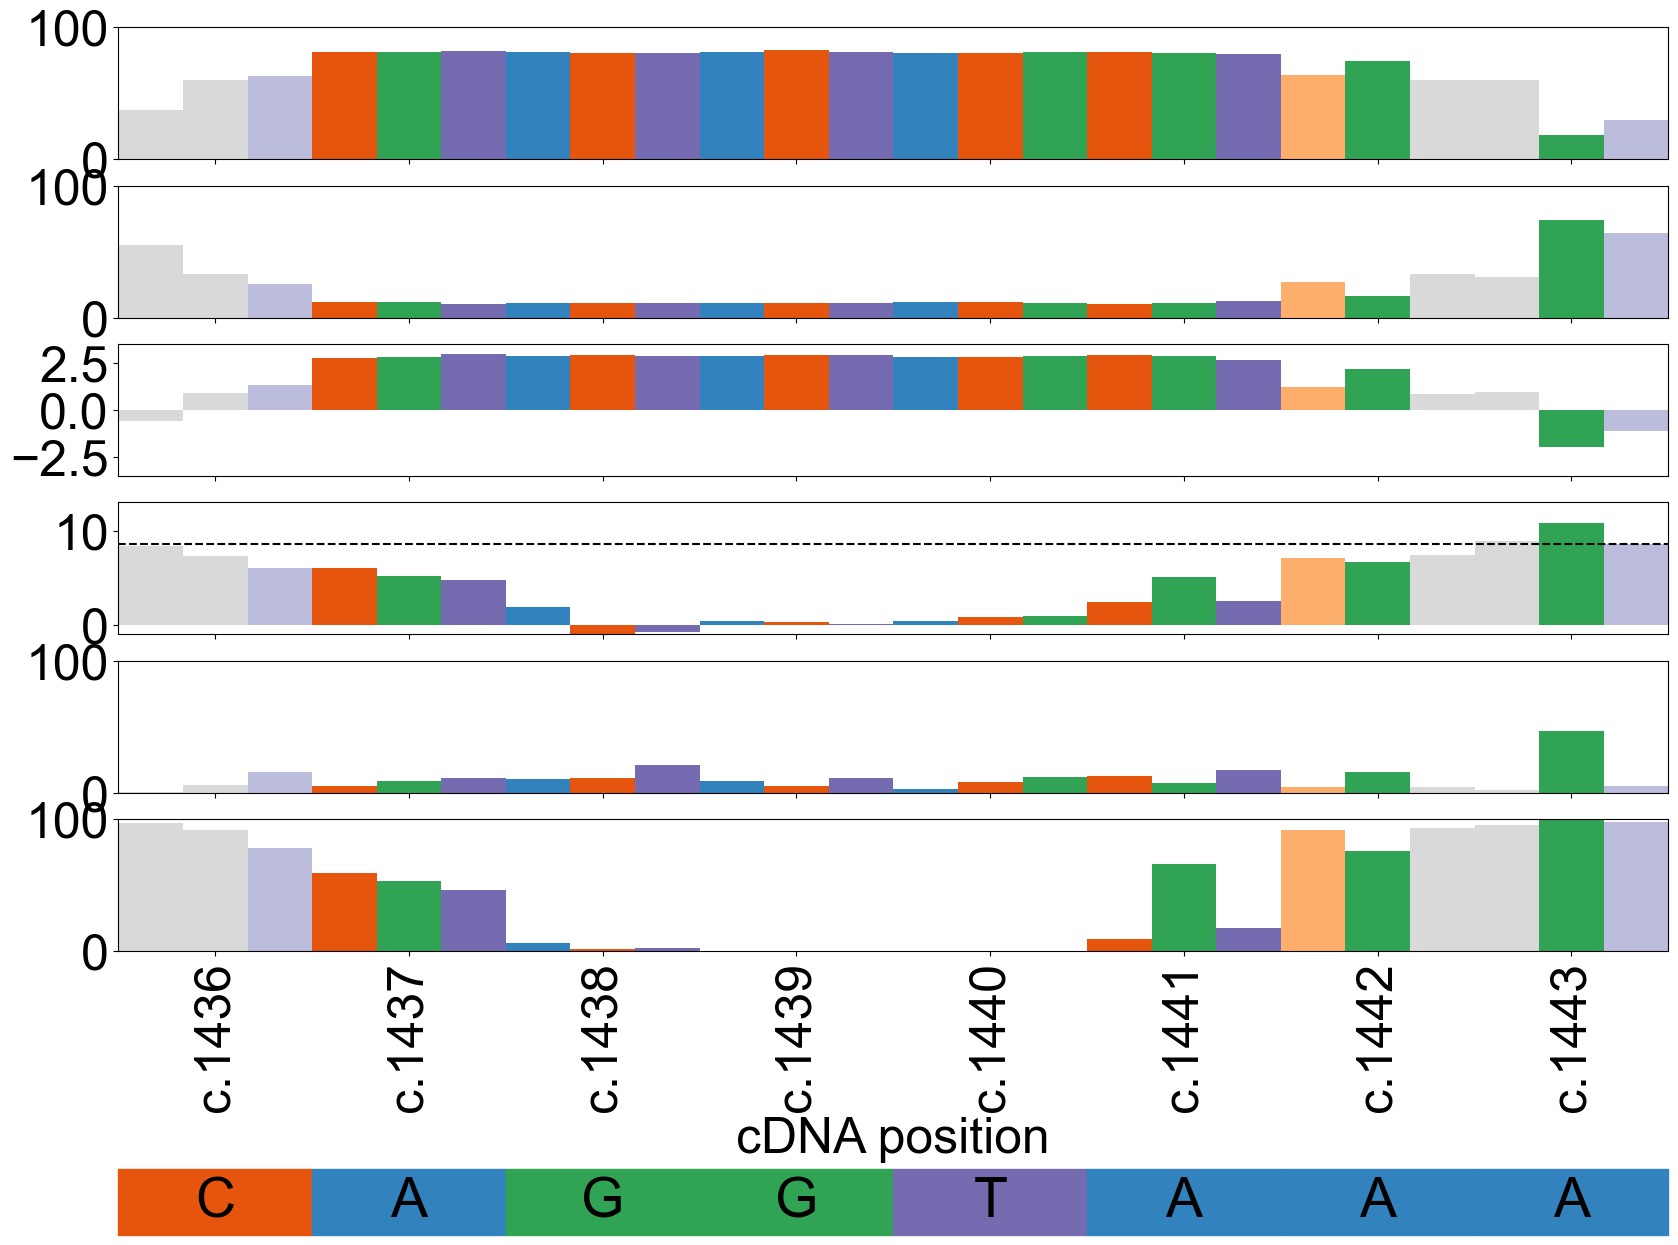

In [169]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                          kts_neg_plot,
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          zoom = ( 1348, 1355 ),
                          fig_size = ( 20, 12 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                           ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ), ],
                          darken_bars2 = [ ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                           ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ), ],
                          y_ax_lim = [ ( 0, 100 ), ( 0, 100 ), ( -3.5, 3.5 ), ( -1, 13 ), ( 0, 100 ), ( 0, 100 ) ],
                          y_ax_title = [ '' ]*len( kts_neg_plot ),
                          x_ax_title = 'cDNA position',
                          tick_spacing = 1,
                          ref_labels = True,
                          y_ref_cds = -215,
                          colors_ref = [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                          hatch_missing = [ ( 'wmean_SKIP_100', '/' ) ],
                          hlines = [ None,
                                     None,
                                     None,
                                     ( byvartbl_wide_sat.loc[ byvartbl_wide_sat.pos == 1350 ].maxent_wt_don.mean(), 'black', '--' ),
                                     None,
                                     None
                                     ],
                          tight = False,
                          #savefile = plot_out + 'kts-_zoom.pdf'
                     )

In [35]:
byvartbl_wide.loc[ ( byvartbl_wide.pos >= 1348 ) & ( byvartbl_wide.pos <= 1355 ) & ( byvartbl_wide.lit_interp != '' ) ]

,hgvs_pos,hg19_pos,ref,alt,ref_c,alt_c,pos,chrom,varlist,exon_num,...,KTS_+_ratio_log2,wmean_KTS+_100,wmean_KTS-_100,wmean_SKIP_100,wmean_OTHER_100,DS_maxm_100,ss_don_prob_32413527_100,ss_don_prob_32413518_100,bp_wt_prob_100,DBP_max_100
151,c.1437,32413528,T,C,A,G,1349,11,jkp815:1349:A:G,9,...,2.805321,81.107852,11.60318,6.861348,0.521705,8.698803,52.829593,89.634705,NaN,NaN


In [36]:
kts_pos_plot = [ 'wmean_KTS+_100', 'wmean_KTS-_100', 'KTS_+_ratio_log2', 'maxent_KTS+', 'DS_maxm_100', 'ss_don_prob_32413518_100', ]

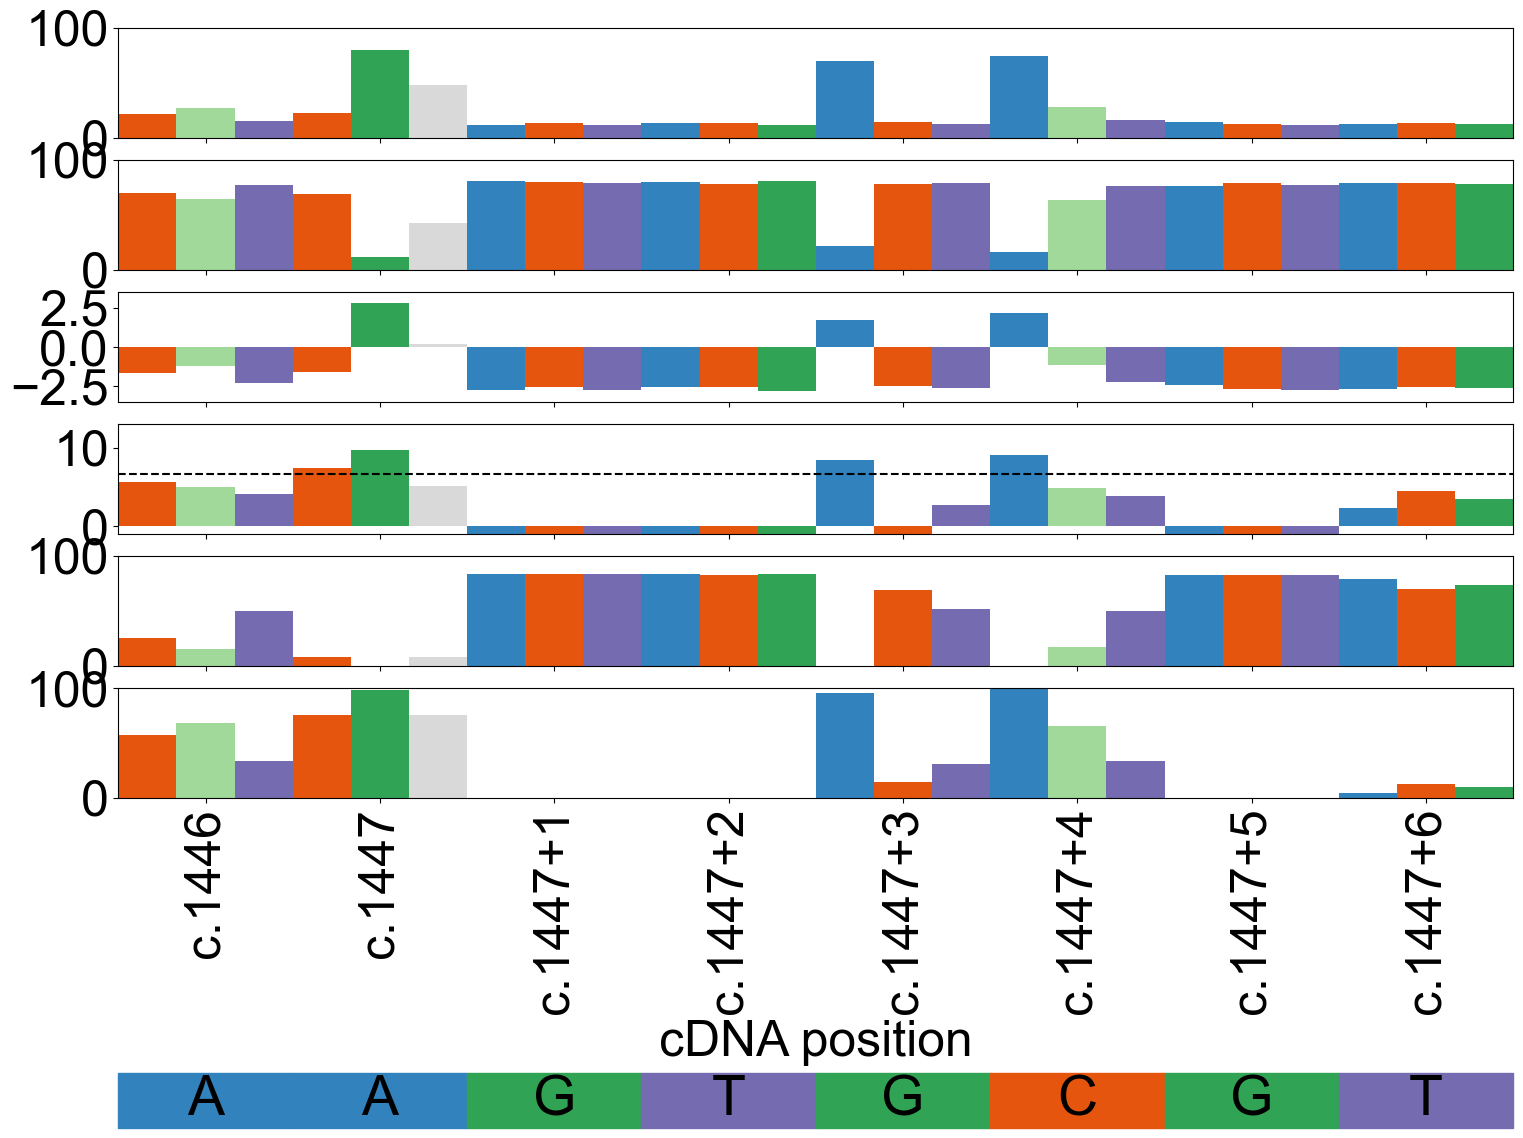

In [170]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                          kts_pos_plot,
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          zoom = ( 1358, 1365 ),
                          fig_size = ( 18, 10 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                           ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ), ],
                          darken_bars2 = [ ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                           ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ), ],
                          y_ax_lim = [ ( 0, 100 ), ( 0, 100 ), ( -3.5, 3.5 ), ( -1, 13 ), ( 0, 100 ), ( 0, 100 ) ],
                          y_ax_title = [ '' ]*len( kts_pos_plot ),
                          x_ax_title = 'cDNA position',
                          tick_spacing = 1,
                          ref_labels = True,
                          y_ref_cds = -300,
                          colors_ref = [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                          hatch_missing = [ ( 'wmean_SKIP_100', '/' ) ],
                          hlines = [ None,
                                     None,
                                     None,
                                     ( byvartbl_wide_sat.loc[ byvartbl_wide_sat.pos == 1359 ].maxent_wt_don.mean(), 'black', '--' ),
                                     None,
                                     None
                                     ],
                          tight = False,
                          #savefile = plot_out + 'kts+_zoom.pdf'
                     )

In [38]:
byvartbl_wide.loc[ ( byvartbl_wide.pos >= 1358 ) & ( byvartbl_wide.pos <= 1365 ) & ( byvartbl_wide.lit_interp == '' ) ]

,hgvs_pos,hg19_pos,ref,alt,ref_c,alt_c,pos,chrom,varlist,exon_num,...,KTS_+_ratio_log2,wmean_KTS+_100,wmean_KTS-_100,wmean_SKIP_100,wmean_OTHER_100,DS_maxm_100,ss_don_prob_32413527_100,ss_don_prob_32413518_100,bp_wt_prob_100,DBP_max_100
103,c.1447+6,32413512,A,G,T,C,1365,11,jkp815:1365:T:C,9,...,-2.524372,13.720837,78.939121,7.203061,0.347679,70.401335,96.803463,12.839241,NaN,NaN
104,c.1447+6,32413512,A,C,T,G,1365,11,jkp815:1365:T:G,9,...,-2.617195,12.738735,78.159248,9.208659,0.311934,73.545337,96.742743,9.695239,NaN,NaN
106,c.1447+5,32413513,C,G,G,C,1364,11,jkp815:1364:G:C,9,...,-2.667202,12.488486,79.326385,8.306518,0.229790,83.163112,98.210239,0.077462,NaN,NaN
108,c.1447+4,32413514,G,T,C,A,1363,11,jkp815:1363:C:A,9,...,2.164480,74.865177,16.699609,8.384486,0.334624,0.356924,81.788099,98.751813,NaN,NaN
109,c.1447+4,32413514,G,C,C,G,1363,11,jkp815:1363:C:G,9,...,-1.156242,28.485387,63.487127,7.840715,0.425222,17.674303,97.586805,65.566272,NaN,NaN
112,c.1447+3,32413515,C,G,G,C,1362,11,jkp815:1362:G:C,9,...,-2.457553,14.284418,78.462067,7.020649,0.382054,68.717760,98.114645,14.522816,NaN,NaN
114,c.1447+2,32413516,A,T,T,A,1361,11,jkp815:1361:T:A,9,...,-2.570941,13.488064,80.145634,5.917894,0.521300,83.224308,97.593373,0.016263,NaN,NaN
116,c.1447+2,32413516,A,C,T,G,1361,11,jkp815:1361:T:G,9,...,-2.806392,11.599078,81.139389,7.232008,0.246792,83.222926,96.989858,0.017650,NaN,NaN
119,c.1447+1,32413517,C,A,G,T,1360,11,jkp815:1360:G:T,9,...,-2.710354,12.117898,79.309511,7.920693,0.717810,83.236784,98.577434,0.003792,NaN,NaN
120,c.1447,32413518,T,G,A,C,1359,11,jkp815:1359:A:C,9,...,-1.597089,22.751222,68.829783,8.360126,0.360422,7.901555,97.764140,75.339019,NaN,NaN


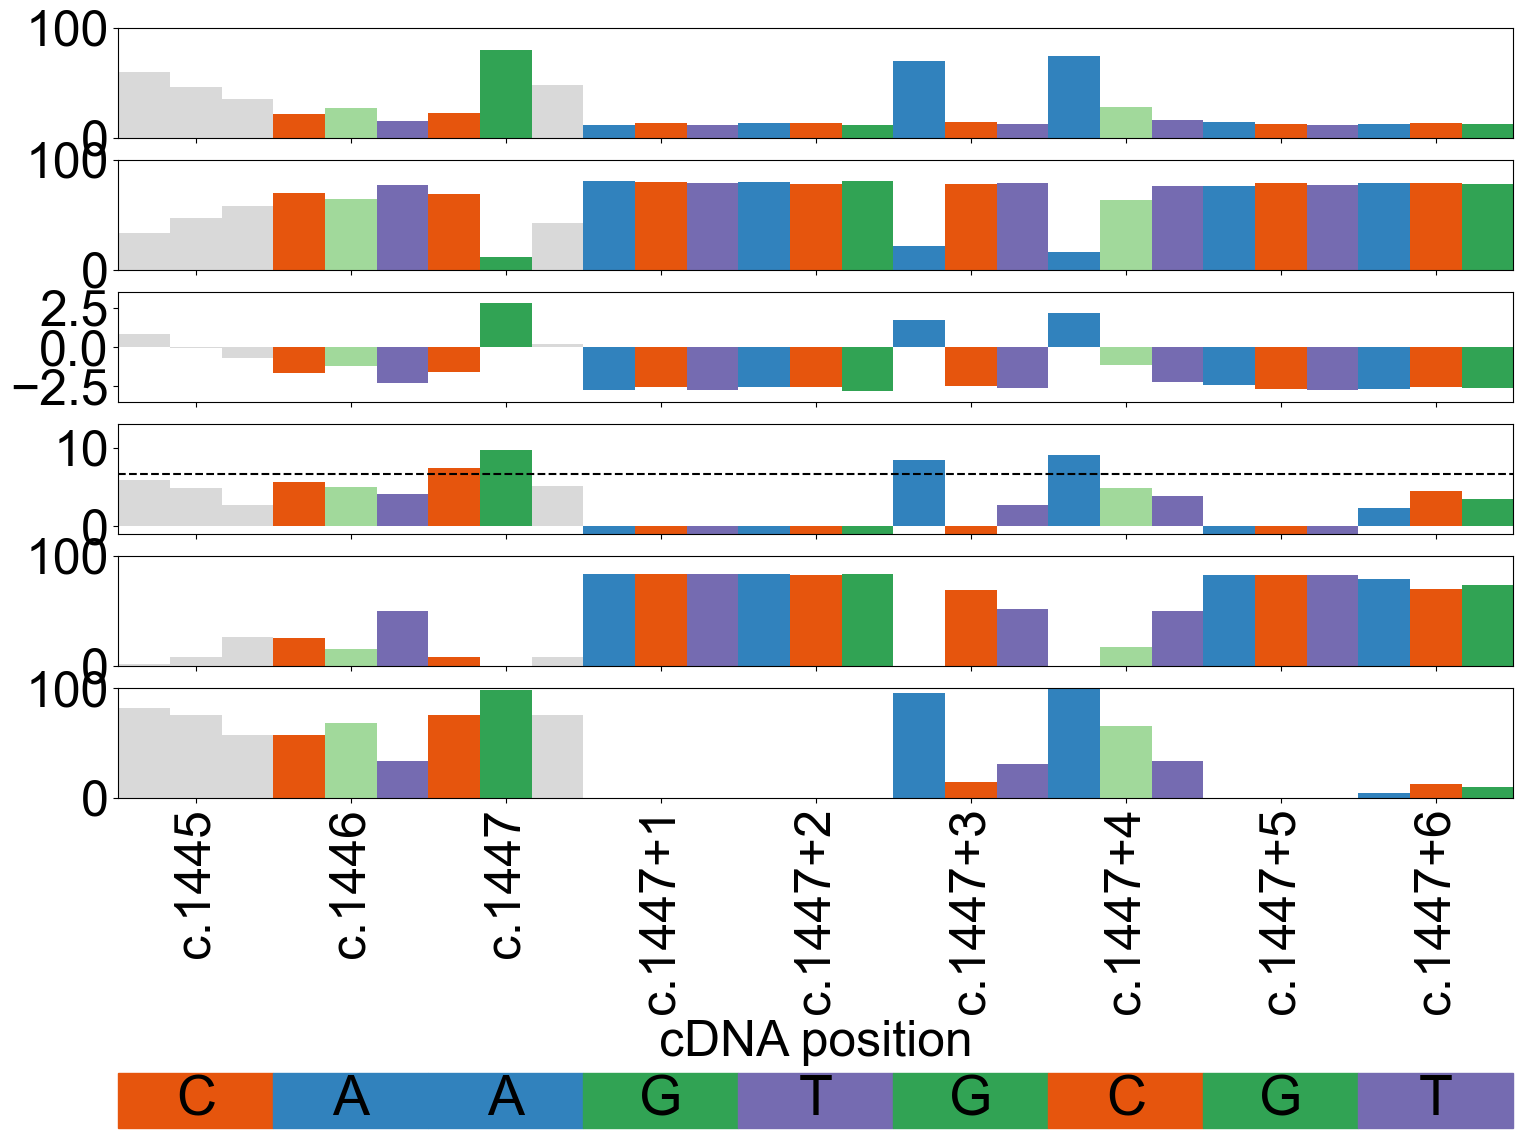

In [172]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                          kts_pos_plot,
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          zoom = ( 1357, 1365 ),
                          fig_size = ( 18, 10 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                           ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ), ],
                          darken_bars2 = [ ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                           ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ), ],
                          y_ax_lim = [ ( 0, 100 ), ( 0, 100 ), ( -3.5, 3.5 ), ( -1, 13 ), ( 0, 100 ), ( 0, 100 ) ],
                          y_ax_title = [ '' ]*len( kts_pos_plot ),
                          x_ax_title = 'cDNA position',
                          tick_spacing = 1,
                          ref_labels = True,
                          y_ref_cds = -300,
                          colors_ref = [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                          hatch_missing = [ ( 'wmean_SKIP_100', '/' ) ],
                          tight = False,
                          hlines = [ None,
                                     None,
                                     None,
                                     ( byvartbl_wide_sat.loc[ byvartbl_wide_sat.pos == 1359 ].maxent_wt_don.mean(), 'black', '--' ),
                                     None,
                                     None
                                     ],
                          savefile = plot_out + 'kts+_zoom2.pdf'
                     )

In [40]:
byvartbl_wide.loc[ ( byvartbl_wide.pos >= 1357 ) & ( byvartbl_wide.pos <= 1365 ) & ( byvartbl_wide.lit_interp != '' ) ]

,hgvs_pos,hg19_pos,ref,alt,ref_c,alt_c,pos,chrom,varlist,exon_num,...,KTS_+_ratio_log2,wmean_KTS+_100,wmean_KTS-_100,wmean_SKIP_100,wmean_OTHER_100,DS_maxm_100,ss_don_prob_32413527_100,ss_don_prob_32413518_100,bp_wt_prob_100,DBP_max_100
102,c.1447+6,32413512,A,T,T,A,1365,11,jkp815:1365:T:A,9,...,-2.647929,12.688233,79.525620,7.639198,0.216104,79.126179,97.108811,4.114395,NaN,NaN
105,c.1447+5,32413513,C,T,G,A,1364,11,jkp815:1364:G:A,9,...,-2.416018,14.356231,76.618614,8.915593,0.439724,83.027709,97.993594,0.212867,NaN,NaN
107,c.1447+5,32413513,C,A,G,T,1364,11,jkp815:1364:G:T,9,...,-2.712676,11.850800,77.686337,10.091601,0.465967,83.135086,98.543626,0.105488,NaN,NaN
110,c.1447+4,32413514,G,A,C,T,1363,11,jkp815:1363:C:T,9,...,-2.196374,16.758837,76.810094,6.509733,0.258271,49.864733,97.976398,33.375841,NaN,NaN
111,c.1447+3,32413515,C,T,G,A,1362,11,jkp815:1362:G:A,9,...,1.702866,69.857534,21.458506,8.637117,0.404015,0.220591,94.685620,95.071185,NaN,NaN
113,c.1447+3,32413515,C,A,G,T,1362,11,jkp815:1362:G:T,9,...,-2.621125,12.925564,79.521883,7.577361,0.254969,52.059984,98.188460,31.180587,NaN,NaN
115,c.1447+2,32413516,A,G,T,C,1361,11,jkp815:1361:T:C,9,...,-2.520973,13.668076,78.450558,7.779899,0.394238,83.051550,98.053598,0.189026,NaN,NaN
117,c.1447+1,32413517,C,T,G,A,1360,11,jkp815:1360:G:A,9,...,-2.753503,11.966772,80.698242,6.908826,0.579344,83.221596,98.082924,0.018977,NaN,NaN
118,c.1447+1,32413517,C,G,G,C,1360,11,jkp815:1360:G:C,9,...,-2.552222,13.632323,79.958596,6.334742,0.330469,83.238488,98.274958,0.002086,NaN,NaN


In [41]:
byvartbl_wide.sdv.sum()

52

In [42]:
byvartbl_wide.sdv.sum() / len( byvartbl_wide )

0.10038610038610038

In [43]:
byvartbl_wide.intmed.sum()

13

In [44]:
byvartbl_wide.intmed.sum() / len( byvartbl_wide )

0.025096525096525095

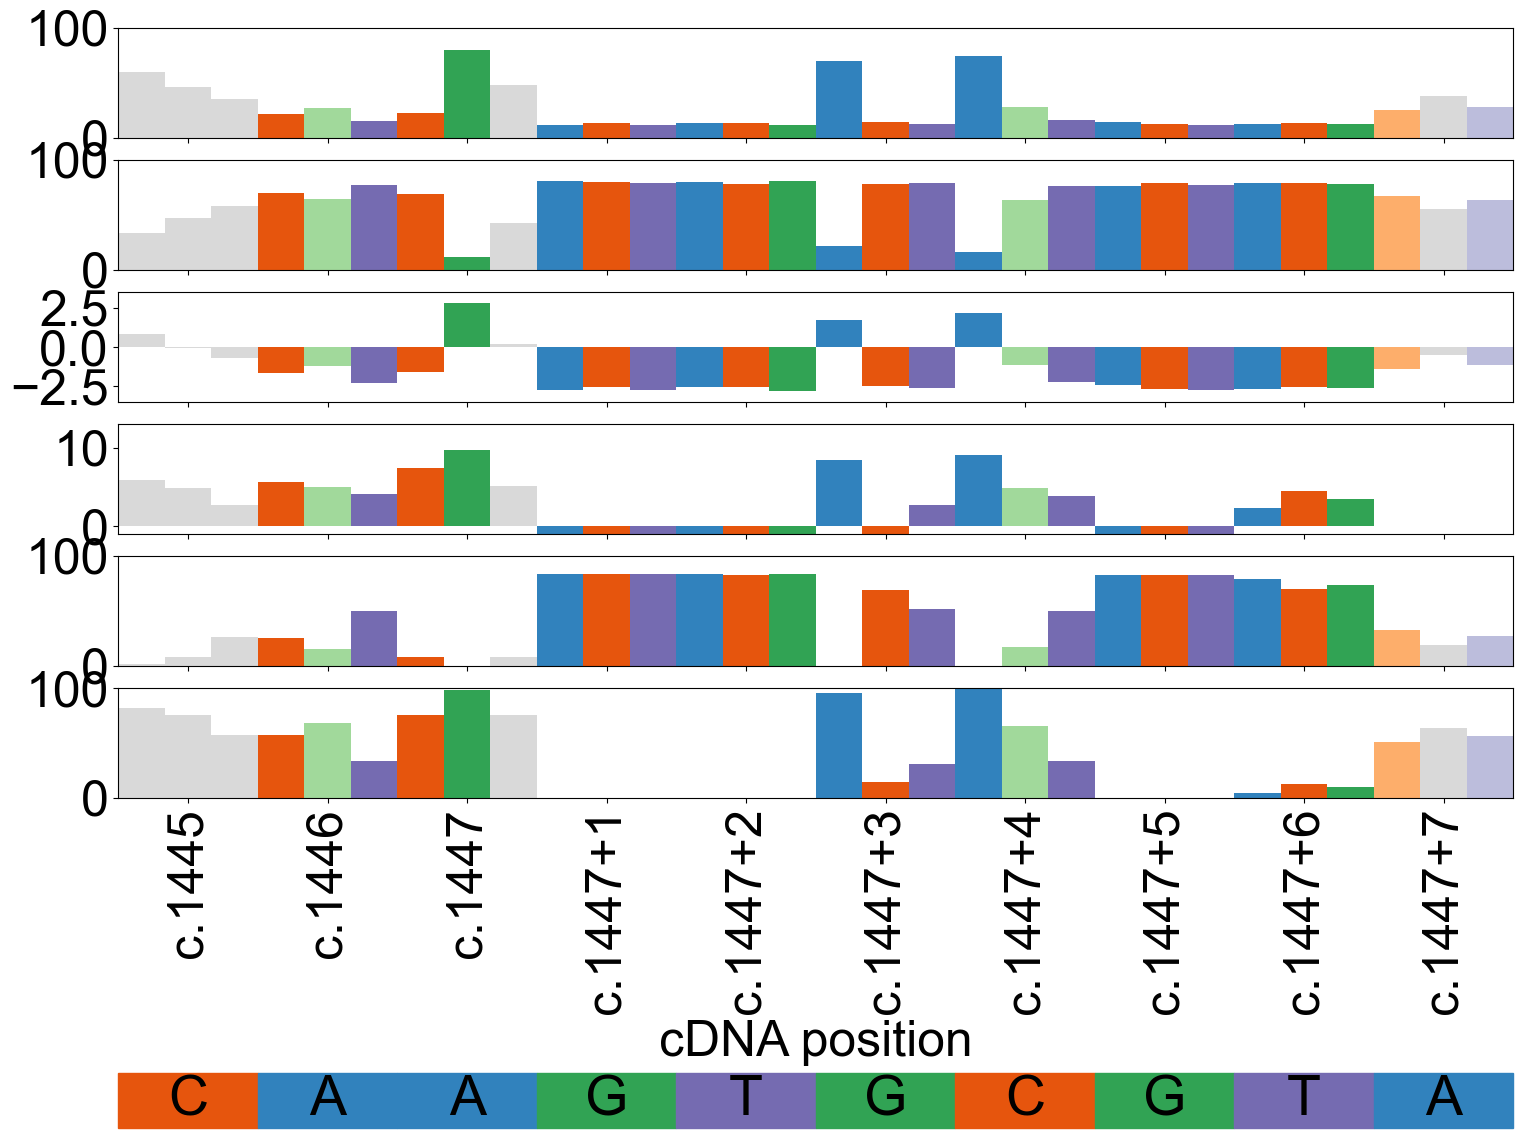

In [75]:
#want to peek at +7A>G
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                          kts_pos_plot,
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          zoom = ( 1357, 1366 ),
                          fig_size = ( 18, 10 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                           ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ), ],
                          darken_bars2 = [ ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                           ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ), ],
                          y_ax_lim = [ ( 0, 100 ), ( 0, 100 ), ( -3.5, 3.5 ), ( -1, 13 ), ( 0, 100 ), ( 0, 100 ) ],
                          y_ax_title = [ '' ]*len( kts_pos_plot ),
                          x_ax_title = 'cDNA position',
                          tick_spacing = 1,
                          ref_labels = True,
                          y_ref_cds = -300,
                          colors_ref = [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                          tight = False,
                          #savefile = plot_out + 'kts+_zoom2.pdf'
                     )

In [45]:
kts_plot = [ 'wmean_KTS+_100', 'wmean_KTS-_100', 'KTS_+_ratio_log2', 'maxent_KTS-', 'maxent_KTS+', 'DS_maxm_100', 'ss_don_prob_32413527_100', 'ss_don_prob_32413518_100', ]

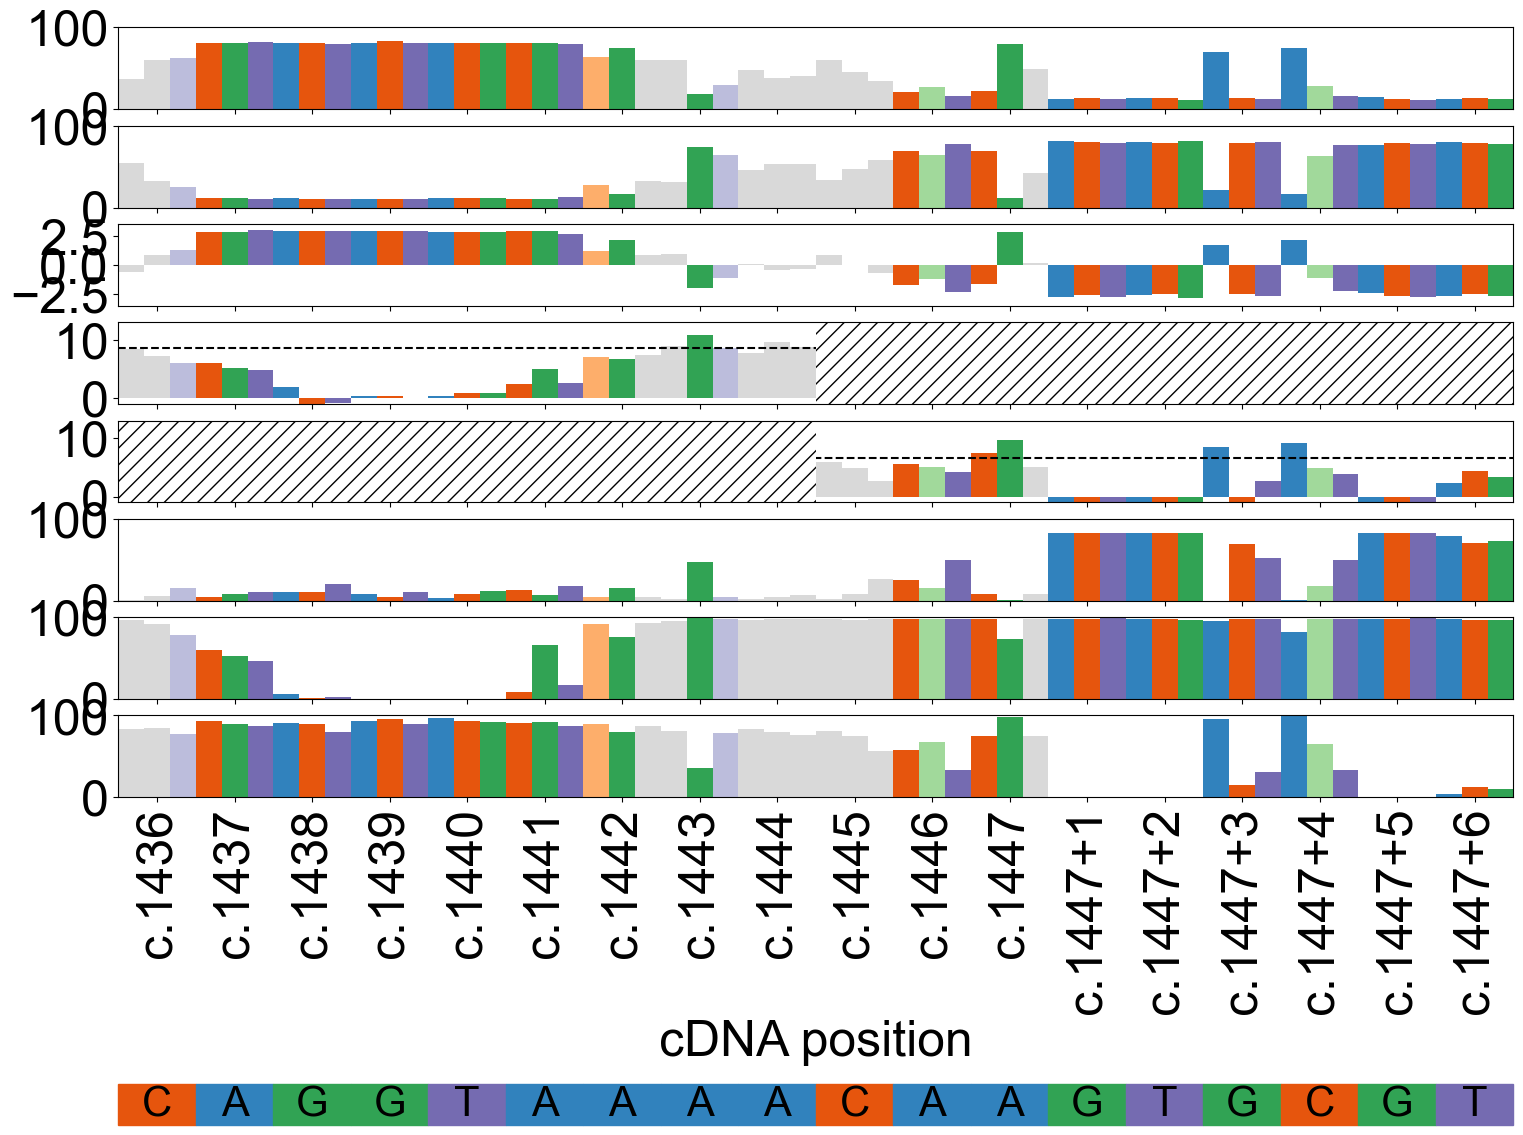

In [185]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                          kts_plot,
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          zoom = ( 1348, 1365 ),
                          fig_size = ( 18, 10 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                           ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ), ],
                          darken_bars2 = [ ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                           ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ), ],
                          y_ax_lim = [ ( 0, 100 ), ( 0, 100 ), ( -3.5, 3.5 ), ( -1, 13 ), ( -1, 13 ), ( 0, 100 ), ( 0, 100 ), ( 0, 100 ) ],
                          y_ax_title = [ '' ]*len( kts_plot ),
                          x_ax_title = 'cDNA position',
                          tick_spacing = 1,
                          ref_labels = True,
                          y_ref_cds = -400,
                          colors_ref = [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                          ref_font_size = 30,
                          hatch_missing = [ ( 'wmean_SKIP_100', '/' ),
                                            ( 'wmean_SKIP_100', '/' ),
                                            ( 'wmean_SKIP_100', '/' ),
                                            ( 'maxent_KTS-', '//' ),
                                            ( 'maxent_KTS+', '//' ),
                                            ( 'wmean_SKIP_100', '/' ),
                                            ( 'wmean_SKIP_100', '/' ),
                                            ( 'wmean_SKIP_100', '/' ),
                                            ],
                          hlines = [ None,
                                     None,
                                     None,
                                     ( byvartbl_wide_sat.loc[ byvartbl_wide_sat.pos == 1350 ].maxent_wt_don.mean(), 'black', '--' ),
                                     ( byvartbl_wide_sat.loc[ byvartbl_wide_sat.pos == 1359 ].maxent_wt_don.mean(), 'black', '--' ),
                                     None,
                                     None,
                                     None
                                     ],
                          tight = False,
                          savefile = plot_out + 'kts_comb_zoom.pdf'
                     )

In [47]:
byvartbl_wide.loc[ ( byvartbl_wide.pos >= 1348 ) & ( byvartbl_wide.pos <= 1365 ) & ( byvartbl_wide.lit_interp != '' ) ]

,hgvs_pos,hg19_pos,ref,alt,ref_c,alt_c,pos,chrom,varlist,exon_num,...,KTS_+_ratio_log2,wmean_KTS+_100,wmean_KTS-_100,wmean_SKIP_100,wmean_OTHER_100,DS_maxm_100,ss_don_prob_32413527_100,ss_don_prob_32413518_100,bp_wt_prob_100,DBP_max_100
102,c.1447+6,32413512,A,T,T,A,1365,11,jkp815:1365:T:A,9,...,-2.647929,12.688233,79.525620,7.639198,0.216104,79.126179,97.108811,4.114395,NaN,NaN
105,c.1447+5,32413513,C,T,G,A,1364,11,jkp815:1364:G:A,9,...,-2.416018,14.356231,76.618614,8.915593,0.439724,83.027709,97.993594,0.212867,NaN,NaN
107,c.1447+5,32413513,C,A,G,T,1364,11,jkp815:1364:G:T,9,...,-2.712676,11.850800,77.686337,10.091601,0.465967,83.135086,98.543626,0.105488,NaN,NaN
110,c.1447+4,32413514,G,A,C,T,1363,11,jkp815:1363:C:T,9,...,-2.196374,16.758837,76.810094,6.509733,0.258271,49.864733,97.976398,33.375841,NaN,NaN
111,c.1447+3,32413515,C,T,G,A,1362,11,jkp815:1362:G:A,9,...,1.702866,69.857534,21.458506,8.637117,0.404015,0.220591,94.685620,95.071185,NaN,NaN
113,c.1447+3,32413515,C,A,G,T,1362,11,jkp815:1362:G:T,9,...,-2.621125,12.925564,79.521883,7.577361,0.254969,52.059984,98.188460,31.180587,NaN,NaN
115,c.1447+2,32413516,A,G,T,C,1361,11,jkp815:1361:T:C,9,...,-2.520973,13.668076,78.450558,7.779899,0.394238,83.051550,98.053598,0.189026,NaN,NaN
117,c.1447+1,32413517,C,T,G,A,1360,11,jkp815:1360:G:A,9,...,-2.753503,11.966772,80.698242,6.908826,0.579344,83.221596,98.082924,0.018977,NaN,NaN
118,c.1447+1,32413517,C,G,G,C,1360,11,jkp815:1360:G:C,9,...,-2.552222,13.632323,79.958596,6.334742,0.330469,83.238488,98.274958,0.002086,NaN,NaN
151,c.1437,32413528,T,C,A,G,1349,11,jkp815:1349:A:G,9,...,2.805321,81.107852,11.603180,6.861348,0.521705,8.698803,52.829593,89.634705,NaN,NaN


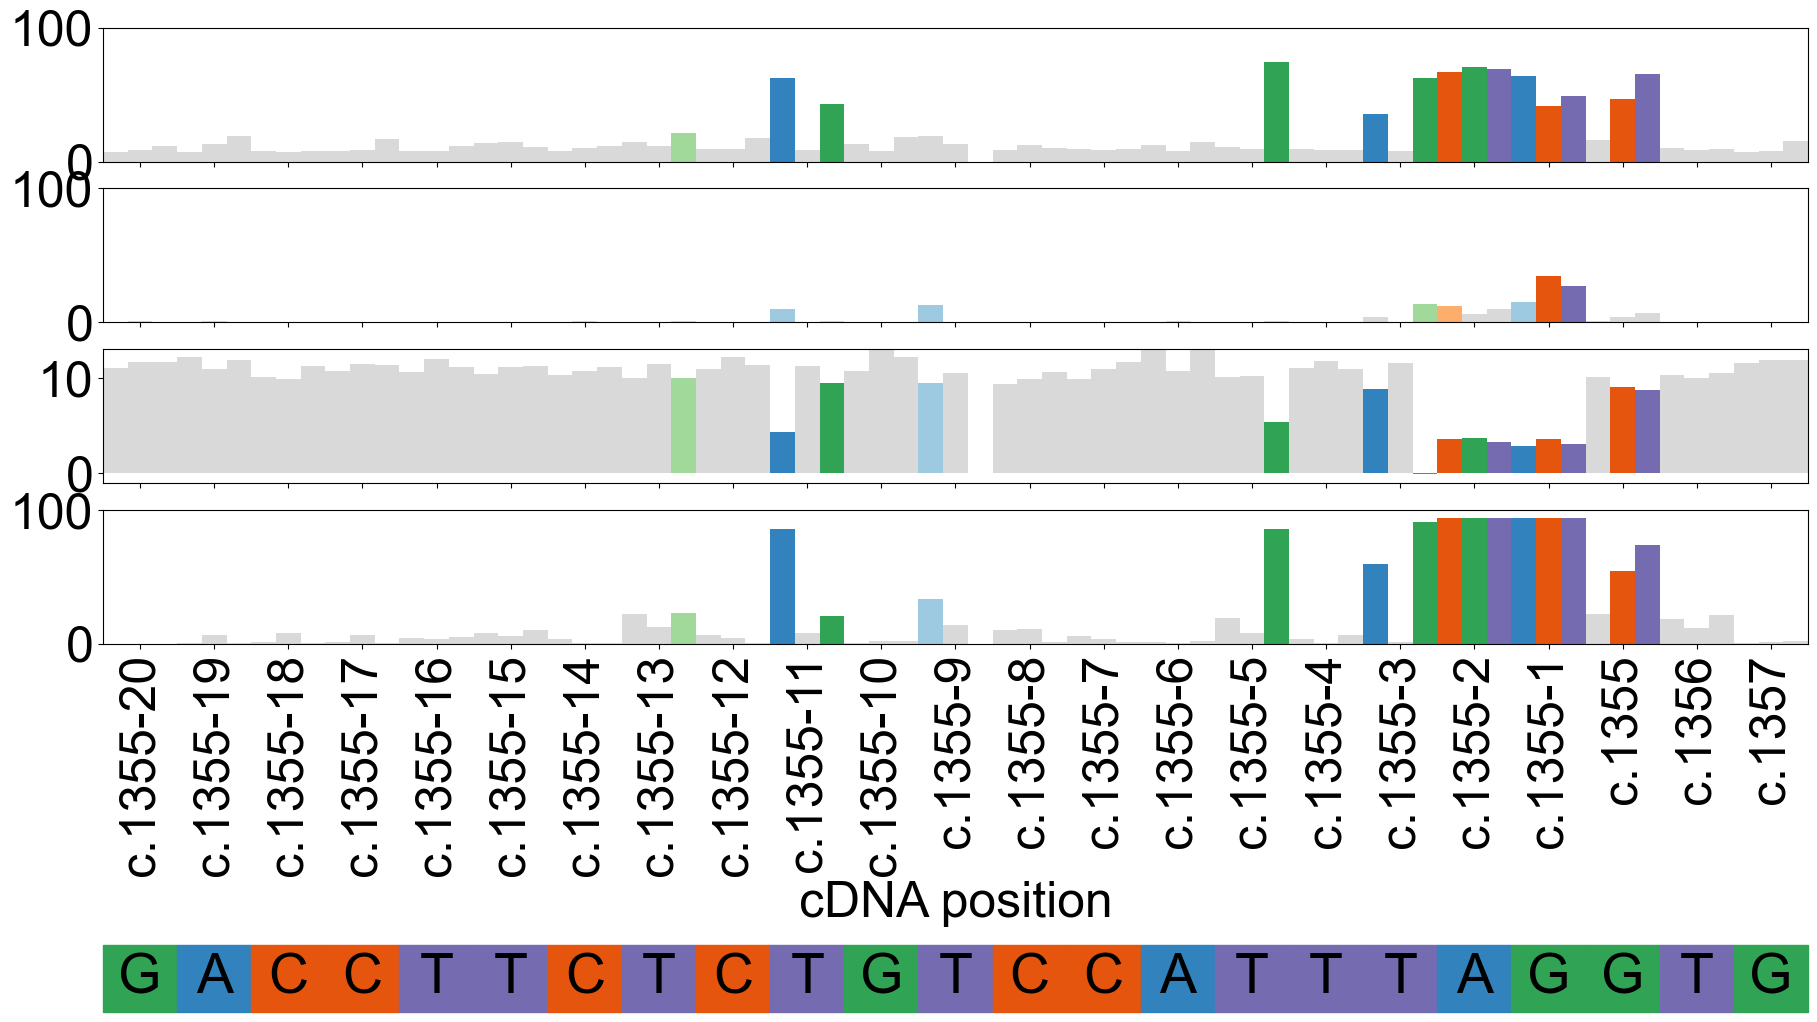

In [48]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                          acc_plot,
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          zoom = ( 1247, 1269 ),
                          fig_size = ( 22, 8 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ), ],
                          darken_bars2 = [ ( 'sdv_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ), ],
                          y_ax_lim = [ ( 0, 100 ), ( 0, 100 ), ( -1, 13 ), ( 0, 100 ), ],
                          y_ax_title = [ '' ]*len( acc_plot ),
                          x_ax_title = 'cDNA position',
                          tick_spacing = 1,
                          ref_labels = True,
                          y_ref_cds = -275,
                          colors_ref = [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                          tight = False,
                          #savefile = plot_out + 'acc_zoom.pdf'
                     )

In [49]:
byvartbl_wide[ 'sdv_ss' ] = ( byvartbl_wide.sdv ) \
                            & ( ( byvartbl_wide.pos == 1265 ) | ( byvartbl_wide.pos == 1266 ) \
                                | ( byvartbl_wide.pos == 1351 ) | ( byvartbl_wide.pos == 1352 ) \
                                | ( byvartbl_wide.pos == 1360 ) | ( byvartbl_wide.pos == 1361 ) ) 

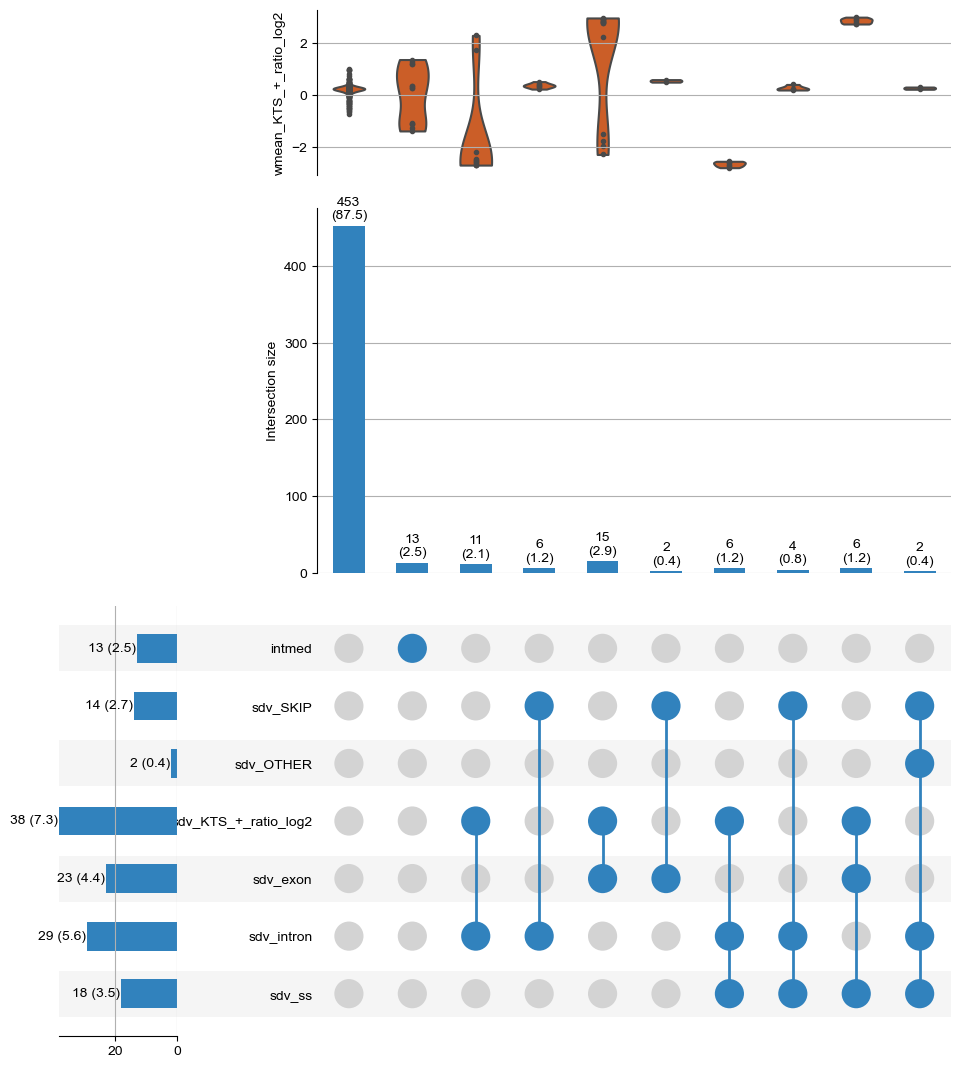

In [50]:
sp.upset_plot( byvartbl_wide, 
               [ 'intmed', 'sdv_SKIP', 'sdv_OTHER', 'sdv_KTS_+_ratio_log2', 'sdv_exon', 'sdv_intron', 'sdv_ss', ][ ::-1 ],
                ( 14, 14 ),
                [ 'wmean_KTS_+_ratio_log2' ],
                [ 'violin' ],
                [ light_colors[ 4 ] ],
                show_counts = '%d',
                show_percentages = '%.1f',
                facecolor = light_colors[ 0 ],
                element_size = 60,
               sort_categories_by = None,
               savefig = plot_out + 'sdv_upset.pdf'
              )

In [51]:
byvartbl_wide[ 'hgvs_var' ] = [ p + ':' + ra[ 0 ] + '>' + ra[ 1 ]
                                for p, ra in zip ( byvartbl_wide.hgvs_pos, zip( byvartbl_wide.ref_c, byvartbl_wide.alt_c ) ) ]

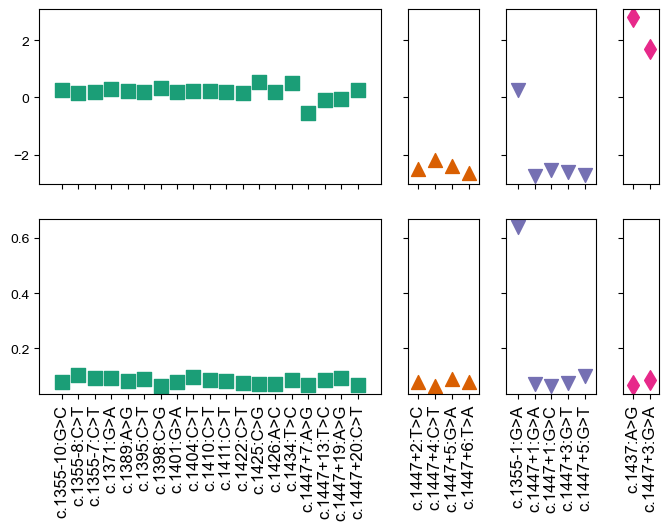

In [52]:
#moved this in from merge_lit_vars.2022-0721
tbv = byvartbl_wide.loc[ byvartbl_wide.lit_interp != '' ].copy()

fig,ax = plt.subplots( 2, len( tbv.lit_interp.unique() ),
                       gridspec_kw = { 'width_ratios' : [ len( tbv.loc[ tbv.lit_interp == l ] ) for l in tbv.lit_interp.unique() ] },
                       sharex = 'col',
                       sharey = 'row',
                       figsize = ( 8, 5 ) )

markers = [ '+', '*', '.', 'D', 'v' ]

colors = plt.get_cmap( 'Dark2' )

for i,interp in enumerate( tbv.lit_interp.unique() ):
    
    interp_df = tbv.loc[ tbv.lit_interp == interp ].sort_values( by = 'pos' ).reset_index().copy()
    
    ax[ 0 ][ i ].scatter( interp_df.index,
                     interp_df[ 'KTS_+_ratio_log2' ],
                     marker = lit_marker_d[ interp ],
                     color = colors( i ),
                     s = 100 )
    
    ax[ 1 ][ i ].scatter( interp_df.index,
                     interp_df.wmean_SKIP,
                     marker = lit_marker_d[ interp ],
                     color = colors( i ),
                     s = 100 )
    
    #i_title = interp
    
    #if '(' in i_title:
        
        #i_title = i_title.split( '(' )[ 0 ] + '\n' + i_title.split( '(' )[ 1 ][ :-1 ]
        
    #if '/' in i_title:
        
        #i_title = i_title.split( '/' )[ 0 ] + '\n' + i_title.split( '/' )[ 1 ]
    
    #ax[ 0 ][ i ].set_title( i_title )
    
    #ax[ 1 ][ i ].set_ylim( ( 0, 1 ) )
    
    x_l,x_r = ax[ 0 ][ i ].get_xlim()
    
    #my stupid markers keep getting cut off
    ax[ 0 ][ i ].set_xlim( ( x_l - .5, x_r + .5 ) )
    ax[ 1 ][ i ].set_xlim( ( x_l - .5, x_r + .5 ) )
    
    ax[ 1 ][ i ].set_xticks(  interp_df.index )
    
    ax[ 1 ][ i ].set_xticklabels( interp_df.hgvs_var,
                                  fontsize=12,
                                  rotation='vertical' )
    
#ax[ 0 ][ 0 ].set_ylabel( 'KTS+ ratio log2' )
#ax[ 1 ][ 0 ].set_ylabel( 'SKIP PSI' )

#ax[ 1 ].set_xlabel( 'hg19 position' )

plt.show()

In [53]:
byvartbl_wide.loc[ byvartbl_wide.lit_interp == 'Likely benign/benign' ].sdv.sum()

0

In [54]:
byvartbl_wide.loc[ byvartbl_wide.lit_interp == 'Likely benign/benign' ].intmed.sum()

0

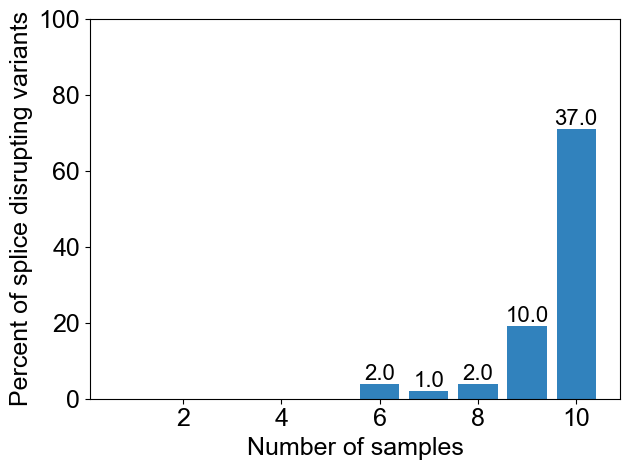

In [55]:
sp.barplot_per_repeat( byvartbl_wide.loc[ byvartbl_wide[ 'sdv' ] ],
                    'sdv_sum',
                    10,
                    ylim = ( 0, 100 ),
                    ylabel = 'Percent of splice disrupting variants',
                    xlabel = 'Number of samples',
                    #savefig = plot_out + 'sdv_by_samp.pdf',
                    color = light_colors[ 0 ]
                  )

In [60]:
bp_plot = [ 'wmean_SKIP_100', 'bp_wt_prob_100', 'DBP_max_100', 'zbpp_wt_bps', 'zbpp_wt_ppt', 'zbpp_wt', 'DS_zsc_bps_max', 'DS_zsc_ppt_max', 'DS_zsc_max' ]

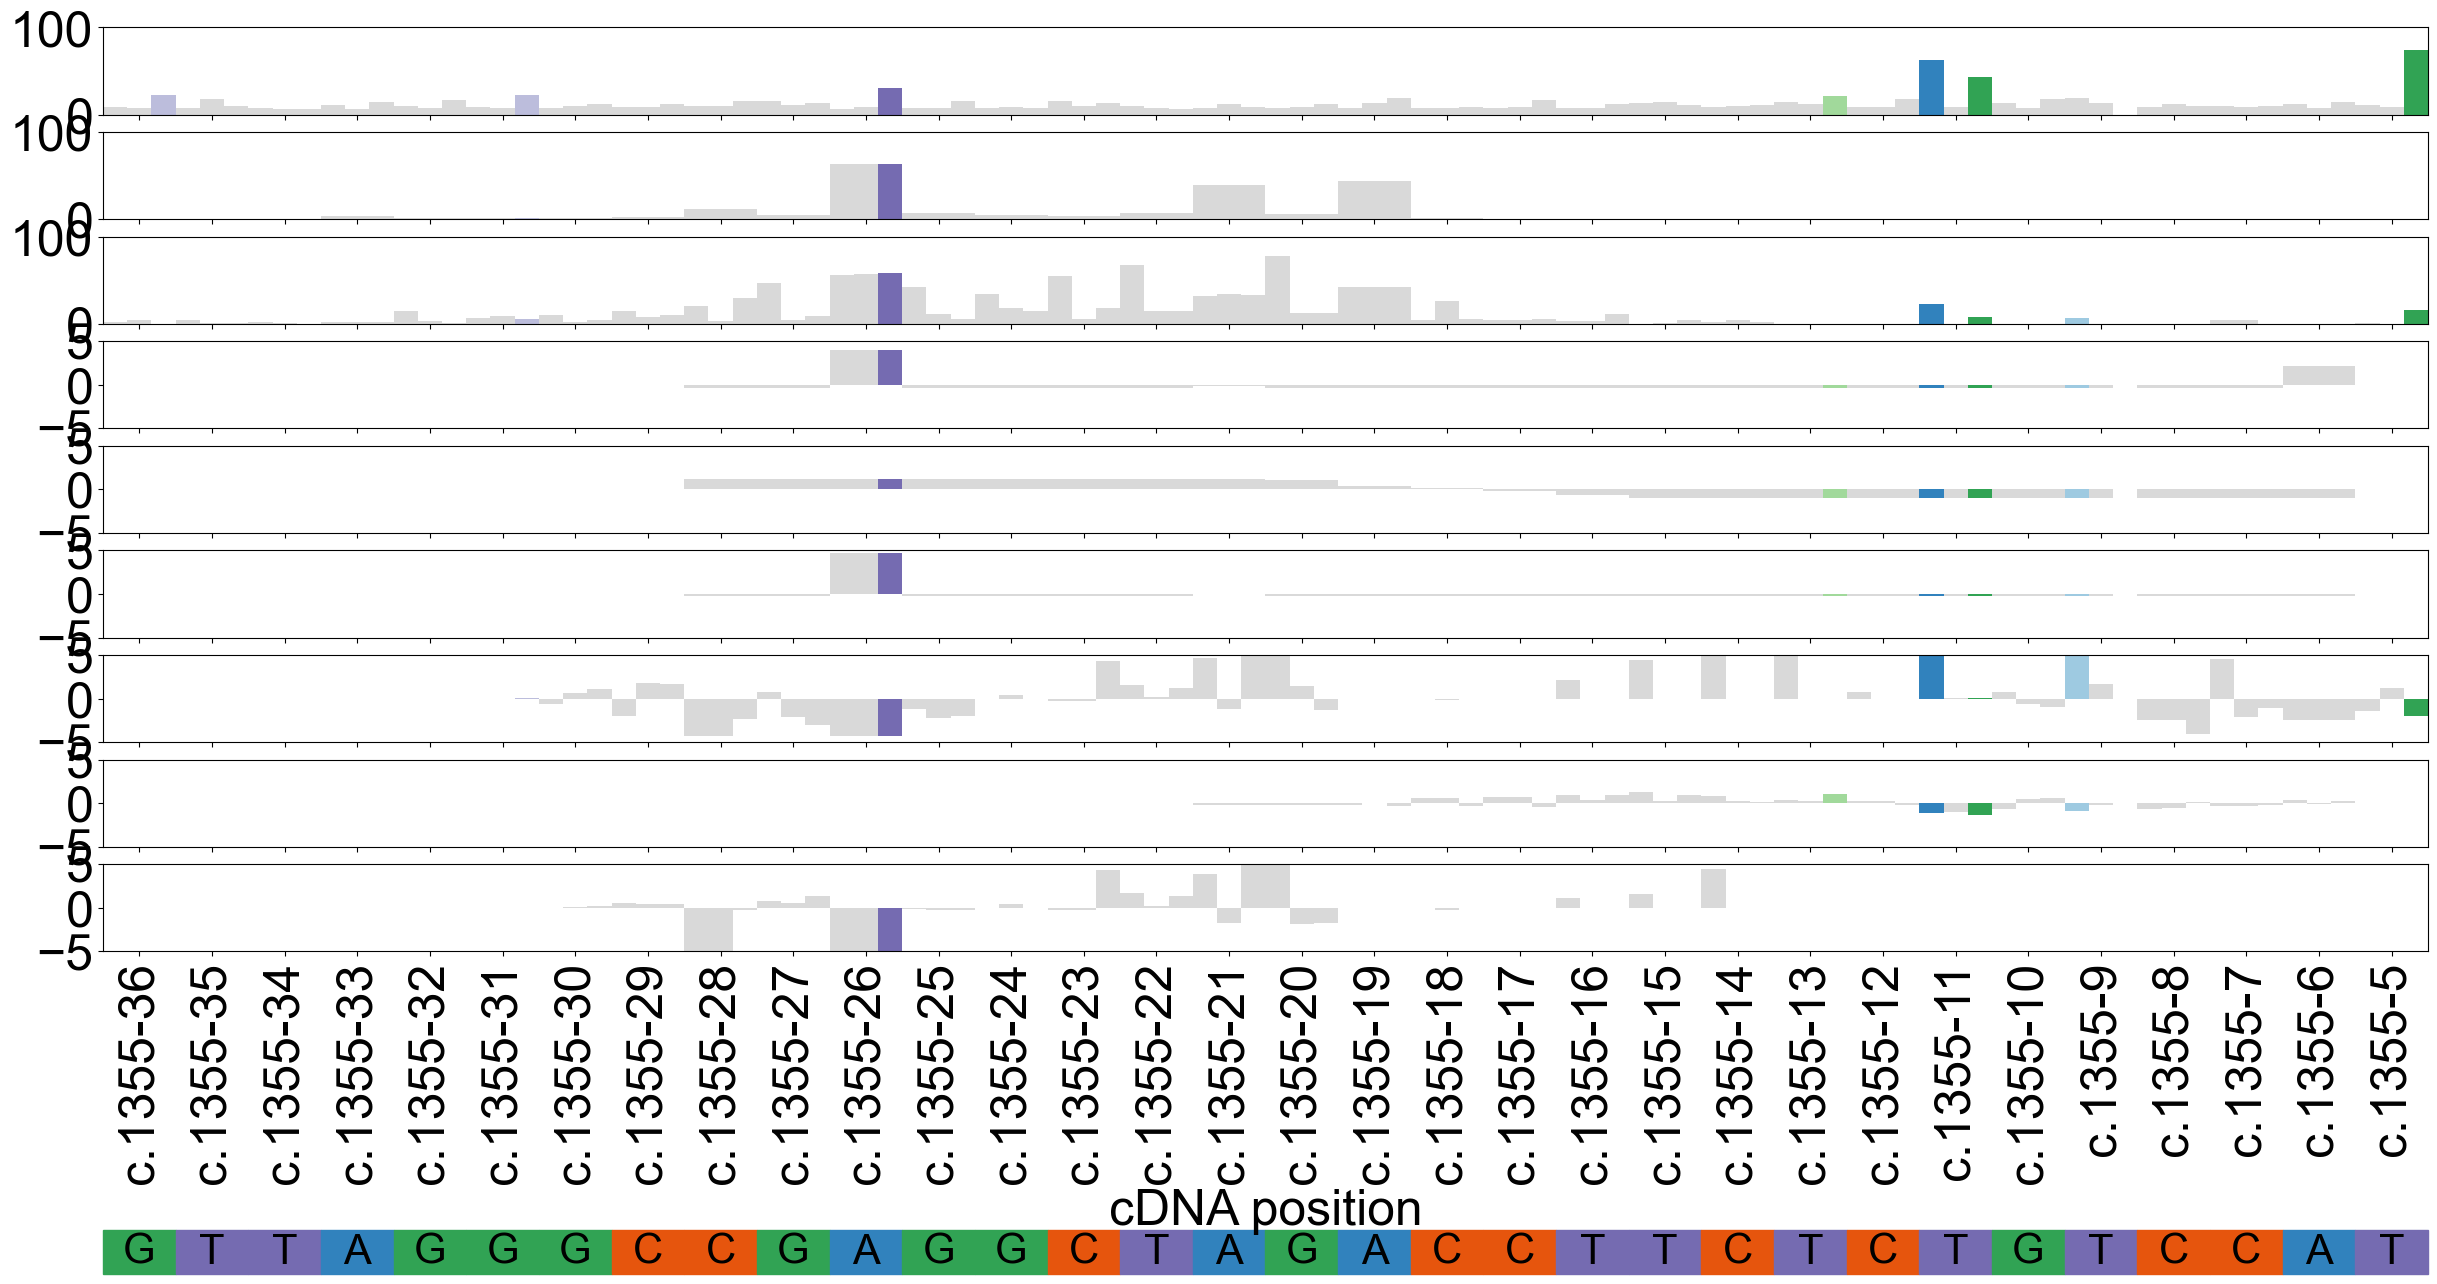

In [61]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                          bp_plot,
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          zoom = ( 1231, 1262 ),
                          fig_size = ( 30, 12 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ), 
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ), ],
                          darken_bars2 = [ ( 'sdv_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ), 
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ), ],
                          y_ax_lim = [ ( 0, 100 ), ( 0, 100 ), ( 0, 100 ), ( -5, 5 ), ( -5, 5 ), ( -5, 5 ), ( -5, 5 ), ( -5, 5 ), ( -5, 5 ) ],
                          y_ax_title = [ '' ]*len( bp_plot ),
                          x_ax_title = 'cDNA position',
                          tick_spacing = 1,
                          ref_labels = True,
                          y_ref_cds = -42,
                          ref_rect_ht = 5,
                          ref_font_size = 30,
                          colors_ref = [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                          tight = False,
                          #savefile = plot_out + 'acc_zoom.pdf'
                     )

In [65]:
bp_plot2 = [ 'wmean_SKIP_100', 'bp_wt_prob_100', 'DBP_max_100', 'zbpp_wt_bps', 'DS_zsc_bps_max', 'DS_zsc_ppt_max', ]

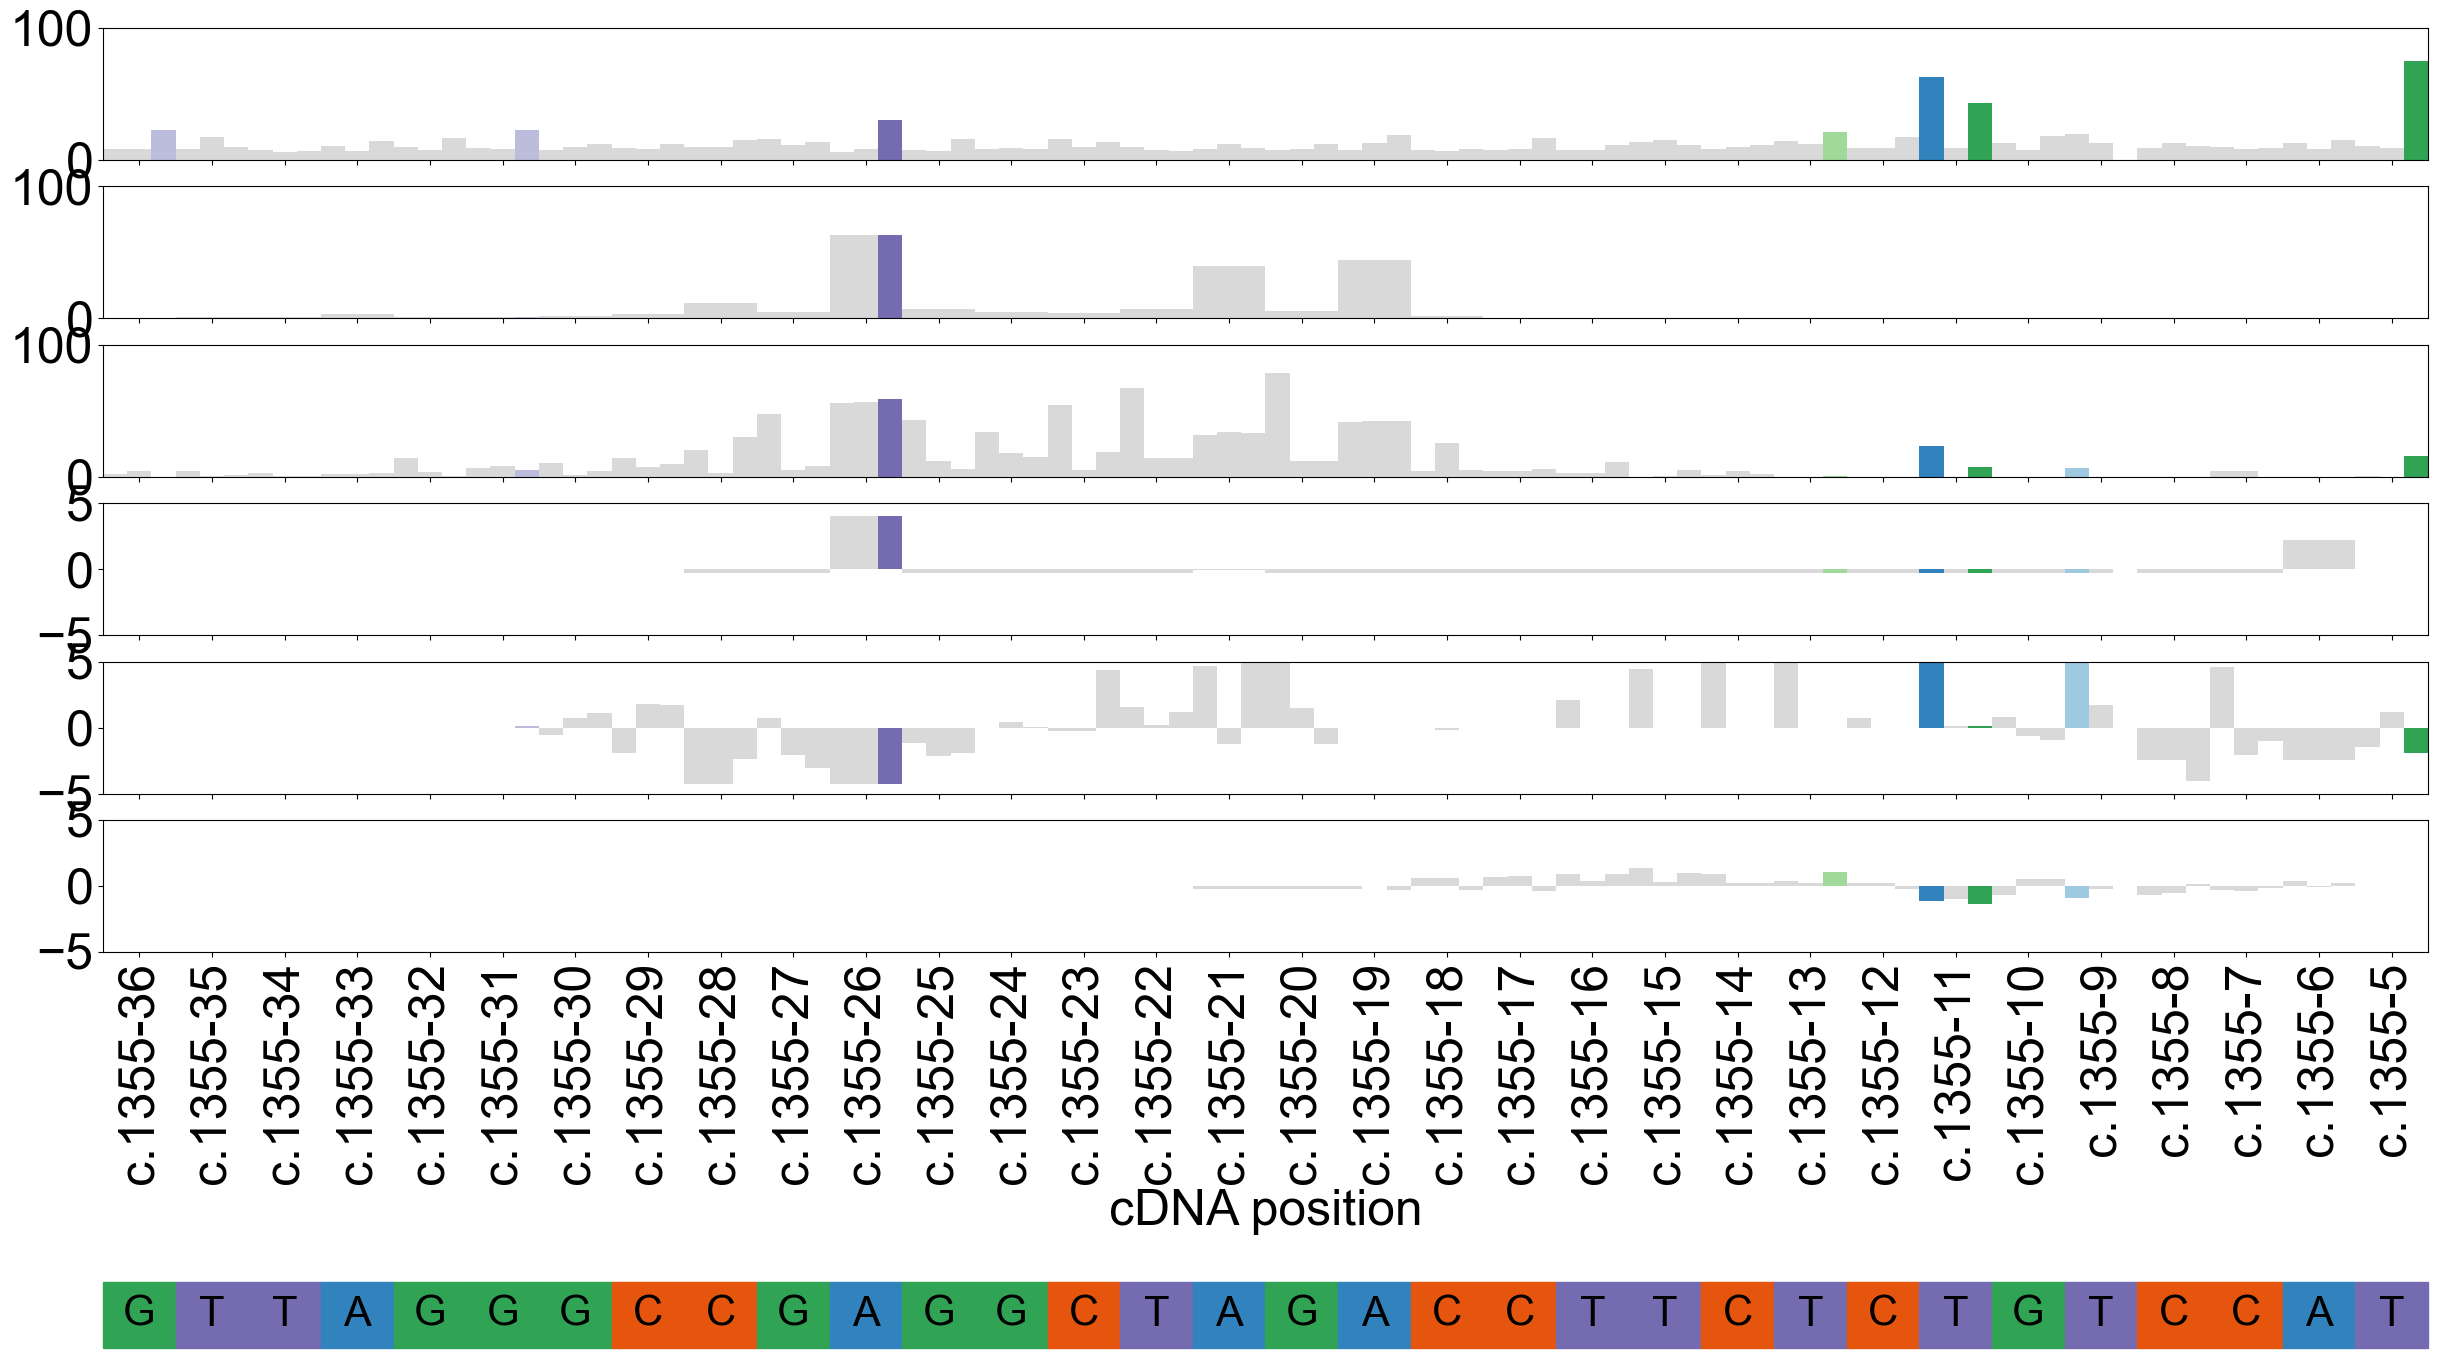

In [66]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                          bp_plot2,
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          zoom = ( 1231, 1262 ),
                          fig_size = ( 30, 12 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ), 
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ),
                                          ( 'intmed' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ), ],
                          darken_bars2 = [ ( 'sdv_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ), 
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ), ],
                          y_ax_lim = [ ( 0, 100 ), ( 0, 100 ), ( 0, 100 ), ( -5, 5 ), ( -5, 5 ), ( -5, 5 ) ],
                          y_ax_title = [ '' ]*len( bp_plot2 ),
                          x_ax_title = 'cDNA position',
                          tick_spacing = 1,
                          ref_labels = True,
                          y_ref_cds = -35,
                          ref_rect_ht = 5,
                          ref_font_size = 30,
                          colors_ref = [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                          tight = False,
                          #savefile = plot_out + 'acc_zoom.pdf'
                     )

In [69]:
byvartbl_wide.loc[ byvartbl_wide.bp_wt_prob.notnull() ]

,hgvs_pos,hg19_pos,ref,alt,ref_c,alt_c,pos,chrom,varlist,exon_num,...,wmean_KTS-_100,wmean_SKIP_100,wmean_OTHER_100,DS_maxm_100,ss_don_prob_32413527_100,ss_don_prob_32413518_100,bp_wt_prob_100,DBP_max_100,sdv_ss,hgvs_var
449,c.1355-18,32413628,G,T,C,A,1249,11,jkp815:1249:C:A,9,...,41.850047,7.801260,0.293165,0.949657,96.451032,NaN,1.903837,4.658228,False,c.1355-18:C>A
450,c.1355-18,32413628,G,C,C,G,1249,11,jkp815:1249:C:G,9,...,42.345615,7.165305,0.247361,8.093423,92.134535,NaN,1.903837,25.899641,False,c.1355-18:C>G
451,c.1355-18,32413628,G,A,C,T,1249,11,jkp815:1249:C:T,9,...,42.059339,8.193540,0.256444,0.689185,97.661114,NaN,1.903837,5.212959,False,c.1355-18:C>T
452,c.1355-19,32413629,T,G,A,C,1248,11,jkp815:1248:A:C,9,...,41.739143,7.404397,0.342096,0.701952,97.673881,NaN,44.233811,41.820934,False,c.1355-19:A>C
453,c.1355-19,32413629,T,C,A,G,1248,11,jkp815:1248:A:G,9,...,41.621362,12.875447,1.153022,6.641918,93.669844,NaN,44.233811,41.931557,False,c.1355-19:A>G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,c.1355-39,32413649,T,C,A,G,1228,11,jkp815:1228:A:G,9,...,41.278386,9.036793,0.475339,0.198542,NaN,NaN,1.082508,0.587492,False,c.1355-39:A>G
514,c.1355-39,32413649,T,A,A,T,1228,11,jkp815:1228:A:T,9,...,39.349527,13.323227,0.362180,2.050559,NaN,NaN,1.082508,0.599562,False,c.1355-39:A>T
515,c.1355-40,32413650,G,T,C,A,1227,11,jkp815:1227:C:A,9,...,42.112060,8.717655,0.423001,0.591718,NaN,NaN,0.502019,0.385936,False,c.1355-40:C>A
516,c.1355-40,32413650,G,C,C,G,1227,11,jkp815:1227:C:G,9,...,42.094588,8.540601,0.346031,0.470360,NaN,NaN,0.502019,0.287220,False,c.1355-40:C>G


In [70]:
byvartbl_wide.loc[ byvartbl_wide.DBP_max.notnull() ]

,hgvs_pos,hg19_pos,ref,alt,ref_c,alt_c,pos,chrom,varlist,exon_num,...,wmean_KTS-_100,wmean_SKIP_100,wmean_OTHER_100,DS_maxm_100,ss_don_prob_32413527_100,ss_don_prob_32413518_100,bp_wt_prob_100,DBP_max_100,sdv_ss,hgvs_var
399,c.1355-1,32413611,C,T,G,A,1266,11,jkp815:1266:G:A,9,...,9.631679,63.932414,14.904771,94.007826,67.206919,45.648423,NaN,7.010762,True,c.1355-1:G>A
400,c.1355-1,32413611,C,G,G,C,1266,11,jkp815:1266:G:C,9,...,10.593402,41.858541,34.890177,93.863916,69.515669,48.887640,NaN,23.271271,True,c.1355-1:G>C
401,c.1355-1,32413611,C,A,G,T,1266,11,jkp815:1266:G:T,9,...,11.165335,48.667545,27.027136,93.994564,70.261127,49.351478,NaN,23.271271,True,c.1355-1:G>T
402,c.1355-2,32413612,T,G,A,C,1265,11,jkp815:1265:A:C,9,...,9.708043,67.015450,12.029543,93.968213,70.180762,49.111256,NaN,22.481757,True,c.1355-2:A>C
403,c.1355-2,32413612,T,C,A,G,1265,11,jkp815:1265:A:G,9,...,10.696667,70.645962,6.225549,93.972939,62.792391,41.951266,NaN,22.271111,True,c.1355-2:A>G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,c.1355-39,32413649,T,C,A,G,1228,11,jkp815:1228:A:G,9,...,41.278386,9.036793,0.475339,0.198542,NaN,NaN,1.082508,0.587492,False,c.1355-39:A>G
514,c.1355-39,32413649,T,A,A,T,1228,11,jkp815:1228:A:T,9,...,39.349527,13.323227,0.362180,2.050559,NaN,NaN,1.082508,0.599562,False,c.1355-39:A>T
515,c.1355-40,32413650,G,T,C,A,1227,11,jkp815:1227:C:A,9,...,42.112060,8.717655,0.423001,0.591718,NaN,NaN,0.502019,0.385936,False,c.1355-40:C>A
516,c.1355-40,32413650,G,C,C,G,1227,11,jkp815:1227:C:G,9,...,42.094588,8.540601,0.346031,0.470360,NaN,NaN,0.502019,0.287220,False,c.1355-40:C>G


In [71]:
byvartbl_wide.loc[ byvartbl_wide.zbpp_wt_bps.notnull() ]

,hgvs_pos,hg19_pos,ref,alt,ref_c,alt_c,pos,chrom,varlist,exon_num,...,wmean_KTS-_100,wmean_SKIP_100,wmean_OTHER_100,DS_maxm_100,ss_don_prob_32413527_100,ss_don_prob_32413518_100,bp_wt_prob_100,DBP_max_100,sdv_ss,hgvs_var
414,c.1355-6,32413616,T,G,A,C,1261,11,jkp815:1261:A:C,9,...,41.023087,12.584669,0.431832,1.302552,98.274481,89.496422,NaN,0.000000,False,c.1355-6:A>C
415,c.1355-6,32413616,T,C,A,G,1261,11,jkp815:1261:A:G,9,...,42.239137,8.143635,0.740544,0.886441,96.697462,83.304787,NaN,0.000000,False,c.1355-6:A>G
416,c.1355-6,32413616,T,A,A,T,1261,11,jkp815:1261:A:T,9,...,38.219653,14.966126,0.505385,1.907778,98.879707,92.929709,NaN,0.000000,False,c.1355-6:A>T
417,c.1355-7,32413617,G,T,C,A,1260,11,jkp815:1260:C:A,9,...,40.662349,9.796174,0.308860,5.877745,94.886667,77.362829,NaN,4.468562,False,c.1355-7:C>A
418,c.1355-7,32413617,G,C,C,G,1260,11,jkp815:1260:C:G,9,...,41.524615,8.403084,0.450103,3.206855,96.450698,80.033720,NaN,4.468562,False,c.1355-7:C>G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,c.1355-27,32413637,C,G,G,C,1240,11,jkp815:1240:G:C,9,...,41.417918,11.043454,0.419671,0.137956,NaN,NaN,5.140993,4.986935,False,c.1355-27:G>C
478,c.1355-27,32413637,C,A,G,T,1240,11,jkp815:1240:G:T,9,...,39.166021,13.724376,0.479635,0.252748,NaN,NaN,5.140993,8.532757,False,c.1355-27:G>T
479,c.1355-28,32413638,G,T,C,A,1239,11,jkp815:1239:C:A,9,...,42.152873,9.549382,0.299531,2.511710,NaN,NaN,12.029746,19.953878,False,c.1355-28:C>A
480,c.1355-28,32413638,G,C,C,G,1239,11,jkp815:1239:C:G,9,...,41.796869,9.477961,0.368170,2.595758,NaN,NaN,12.029746,2.888014,False,c.1355-28:C>G


In [72]:
byvartbl_wide.loc[ byvartbl_wide.DS_zsc_bps_max.notnull() ]

,hgvs_pos,hg19_pos,ref,alt,ref_c,alt_c,pos,chrom,varlist,exon_num,...,wmean_KTS-_100,wmean_SKIP_100,wmean_OTHER_100,DS_maxm_100,ss_don_prob_32413527_100,ss_don_prob_32413518_100,bp_wt_prob_100,DBP_max_100,sdv_ss,hgvs_var
399,c.1355-1,32413611,C,T,G,A,1266,11,jkp815:1266:G:A,9,...,9.631679,63.932414,14.904771,94.007826,67.206919,45.648423,NaN,7.010762,True,c.1355-1:G>A
400,c.1355-1,32413611,C,G,G,C,1266,11,jkp815:1266:G:C,9,...,10.593402,41.858541,34.890177,93.863916,69.515669,48.887640,NaN,23.271271,True,c.1355-1:G>C
401,c.1355-1,32413611,C,A,G,T,1266,11,jkp815:1266:G:T,9,...,11.165335,48.667545,27.027136,93.994564,70.261127,49.351478,NaN,23.271271,True,c.1355-1:G>T
402,c.1355-2,32413612,T,G,A,C,1265,11,jkp815:1265:A:C,9,...,9.708043,67.015450,12.029543,93.968213,70.180762,49.111256,NaN,22.481757,True,c.1355-2:A>C
403,c.1355-2,32413612,T,C,A,G,1265,11,jkp815:1265:A:G,9,...,10.696667,70.645962,6.225549,93.972939,62.792391,41.951266,NaN,22.271111,True,c.1355-2:A>G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,c.1355-39,32413649,T,C,A,G,1228,11,jkp815:1228:A:G,9,...,41.278386,9.036793,0.475339,0.198542,NaN,NaN,1.082508,0.587492,False,c.1355-39:A>G
514,c.1355-39,32413649,T,A,A,T,1228,11,jkp815:1228:A:T,9,...,39.349527,13.323227,0.362180,2.050559,NaN,NaN,1.082508,0.599562,False,c.1355-39:A>T
515,c.1355-40,32413650,G,T,C,A,1227,11,jkp815:1227:C:A,9,...,42.112060,8.717655,0.423001,0.591718,NaN,NaN,0.502019,0.385936,False,c.1355-40:C>A
516,c.1355-40,32413650,G,C,C,G,1227,11,jkp815:1227:C:G,9,...,42.094588,8.540601,0.346031,0.470360,NaN,NaN,0.502019,0.287220,False,c.1355-40:C>G


In [73]:
byvartbl_wide.loc[ byvartbl_wide.DS_zsc_ppt_max.notnull() ]

,hgvs_pos,hg19_pos,ref,alt,ref_c,alt_c,pos,chrom,varlist,exon_num,...,wmean_KTS-_100,wmean_SKIP_100,wmean_OTHER_100,DS_maxm_100,ss_don_prob_32413527_100,ss_don_prob_32413518_100,bp_wt_prob_100,DBP_max_100,sdv_ss,hgvs_var
399,c.1355-1,32413611,C,T,G,A,1266,11,jkp815:1266:G:A,9,...,9.631679,63.932414,14.904771,94.007826,67.206919,45.648423,NaN,7.010762,True,c.1355-1:G>A
400,c.1355-1,32413611,C,G,G,C,1266,11,jkp815:1266:G:C,9,...,10.593402,41.858541,34.890177,93.863916,69.515669,48.887640,NaN,23.271271,True,c.1355-1:G>C
401,c.1355-1,32413611,C,A,G,T,1266,11,jkp815:1266:G:T,9,...,11.165335,48.667545,27.027136,93.994564,70.261127,49.351478,NaN,23.271271,True,c.1355-1:G>T
402,c.1355-2,32413612,T,G,A,C,1265,11,jkp815:1265:A:C,9,...,9.708043,67.015450,12.029543,93.968213,70.180762,49.111256,NaN,22.481757,True,c.1355-2:A>C
403,c.1355-2,32413612,T,C,A,G,1265,11,jkp815:1265:A:G,9,...,10.696667,70.645962,6.225549,93.972939,62.792391,41.951266,NaN,22.271111,True,c.1355-2:A>G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,c.1355-39,32413649,T,C,A,G,1228,11,jkp815:1228:A:G,9,...,41.278386,9.036793,0.475339,0.198542,NaN,NaN,1.082508,0.587492,False,c.1355-39:A>G
514,c.1355-39,32413649,T,A,A,T,1228,11,jkp815:1228:A:T,9,...,39.349527,13.323227,0.362180,2.050559,NaN,NaN,1.082508,0.599562,False,c.1355-39:A>T
515,c.1355-40,32413650,G,T,C,A,1227,11,jkp815:1227:C:A,9,...,42.112060,8.717655,0.423001,0.591718,NaN,NaN,0.502019,0.385936,False,c.1355-40:C>A
516,c.1355-40,32413650,G,C,C,G,1227,11,jkp815:1227:C:G,9,...,42.094588,8.540601,0.346031,0.470360,NaN,NaN,0.502019,0.287220,False,c.1355-40:C>G


In [76]:
byvartbl_wide.loc[ byvartbl_wide[ 'KTS_+_ratio_log2' ] < 0 ]

,hgvs_pos,hg19_pos,ref,alt,ref_c,alt_c,pos,chrom,varlist,exon_num,...,wmean_KTS-_100,wmean_SKIP_100,wmean_OTHER_100,DS_maxm_100,ss_don_prob_32413527_100,ss_don_prob_32413518_100,bp_wt_prob_100,DBP_max_100,sdv_ss,hgvs_var
44,c.1447+26,32413492,A,C,T,G,1385,11,jkp815:1385:T:G,9,...,51.327109,8.697805,0.264321,8.553916,95.809543,74.686658,NaN,NaN,False,c.1447+26:T>G
50,c.1447+24,32413494,A,C,T,G,1383,11,jkp815:1383:T:G,9,...,46.843179,7.228756,0.395323,4.153001,96.766692,79.087573,NaN,NaN,False,c.1447+24:T>G
53,c.1447+23,32413495,A,C,T,G,1382,11,jkp815:1382:T:G,9,...,49.064874,6.622591,0.360901,2.572364,96.774882,80.668211,NaN,NaN,False,c.1447+23:T>G
56,c.1447+22,32413496,A,C,T,G,1381,11,jkp815:1381:T:G,9,...,51.070086,8.143426,0.304657,7.737589,96.697485,75.502986,NaN,NaN,False,c.1447+22:T>G
61,c.1447+20,32413498,G,C,C,G,1379,11,jkp815:1379:C:G,9,...,45.444599,9.135701,0.117811,6.991130,97.322685,76.249444,NaN,NaN,False,c.1447+20:C>G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,c.1427,32413538,C,T,G,A,1339,11,jkp815:1339:G:A,9,...,55.946377,5.786846,0.167314,2.241200,96.638298,80.999374,NaN,NaN,False,c.1427:G>A
181,c.1427,32413538,C,G,G,C,1339,11,jkp815:1339:G:C,9,...,53.905545,6.676977,0.297644,0.365162,97.337091,86.388808,NaN,NaN,False,c.1427:G>C
182,c.1427,32413538,C,A,G,T,1339,11,jkp815:1339:G:T,9,...,47.674963,7.092324,0.346052,2.642667,95.772868,83.140022,NaN,NaN,False,c.1427:G>T
333,c.1376,32413589,T,G,A,C,1288,11,jkp815:1288:A:C,9,...,47.471089,5.765720,0.464954,2.079708,97.936964,87.651175,NaN,NaN,False,c.1376:A>C


In [79]:
2**-.25

0.8408964152537145

In [78]:
2**-.5

0.7071067811865476

In [80]:
byvartbl_wide.loc[ byvartbl_wide[ 'KTS_+_ratio_log2' ] < -.5 ]

,hgvs_pos,hg19_pos,ref,alt,ref_c,alt_c,pos,chrom,varlist,exon_num,...,wmean_KTS-_100,wmean_SKIP_100,wmean_OTHER_100,DS_maxm_100,ss_don_prob_32413527_100,ss_don_prob_32413518_100,bp_wt_prob_100,DBP_max_100,sdv_ss,hgvs_var
83,c.1447+13,32413505,A,C,T,G,1372,11,jkp815:1372:T:G,9,...,58.192505,6.209622,0.251137,7.865453,96.284884,75.375122,NaN,NaN,False,c.1447+13:T>G
86,c.1447+12,32413506,A,C,T,G,1371,11,jkp815:1371:T:G,9,...,56.640360,7.089811,0.288634,7.214403,95.874512,76.026171,NaN,NaN,False,c.1447+12:T>G
99,c.1447+7,32413511,T,G,A,C,1366,11,jkp815:1366:A:C,9,...,67.207666,7.556744,0.332359,32.687587,96.697843,50.552988,NaN,NaN,False,c.1447+7:A>C
100,c.1447+7,32413511,T,C,A,G,1366,11,jkp815:1366:A:G,9,...,55.101014,6.762207,0.311919,19.155830,96.376687,64.084744,NaN,NaN,False,c.1447+7:A>G
101,c.1447+7,32413511,T,A,A,T,1366,11,jkp815:1366:A:T,9,...,63.484563,7.995381,0.346098,27.112520,98.525047,56.128055,NaN,NaN,False,c.1447+7:A>T
102,c.1447+6,32413512,A,T,T,A,1365,11,jkp815:1365:T:A,9,...,79.525620,7.639198,0.216104,79.126179,97.108811,4.114395,NaN,NaN,False,c.1447+6:T>A
103,c.1447+6,32413512,A,G,T,C,1365,11,jkp815:1365:T:C,9,...,78.939121,7.203061,0.347679,70.401335,96.803463,12.839241,NaN,NaN,False,c.1447+6:T>C
104,c.1447+6,32413512,A,C,T,G,1365,11,jkp815:1365:T:G,9,...,78.159248,9.208659,0.311934,73.545337,96.742743,9.695239,NaN,NaN,False,c.1447+6:T>G
105,c.1447+5,32413513,C,T,G,A,1364,11,jkp815:1364:G:A,9,...,76.618614,8.915593,0.439724,83.027709,97.993594,0.212867,NaN,NaN,False,c.1447+5:G>A
106,c.1447+5,32413513,C,G,G,C,1364,11,jkp815:1364:G:C,9,...,79.326385,8.306518,0.229790,83.163112,98.210239,0.077462,NaN,NaN,False,c.1447+5:G>C


In [81]:
byvartbl_wide.hg19_pos.min()

32413478

In [82]:
byvartbl_wide.hg19_pos.max()

32413650

In [88]:
[ col for col in byvartbl_wide if 'bc' in col ]

['BB_RT_1_340_243_Hek1053_n_bc',
 'BB_RT_1b_340_243_Hek1053_n_bc',
 'BB_RT_1b_ODT_243_Hek1053_n_bc',
 'BB_RT_1_ODT_243_Hek1053_n_bc',
 'BB_RT_2_340_243_Hek1054_n_bc',
 'BB_RT_2_ODT_243_Hek1054_n_bc',
 'BB_RT_3_340_243_Cos1055_n_bc',
 'BB_RT_3_340_243_Hek1055_n_bc',
 'BB_RT_3_ODT_243_Cos1055_n_bc',
 'BB_RT_3_ODT_243_Hek1055_n_bc',
 'BB_RT_1_340_243_Hek1053_n_bc_passfilt',
 'BB_RT_1b_340_243_Hek1053_n_bc_passfilt',
 'BB_RT_1b_ODT_243_Hek1053_n_bc_passfilt',
 'BB_RT_1_ODT_243_Hek1053_n_bc_passfilt',
 'BB_RT_2_340_243_Hek1054_n_bc_passfilt',
 'BB_RT_2_ODT_243_Hek1054_n_bc_passfilt',
 'BB_RT_3_340_243_Cos1055_n_bc_passfilt',
 'BB_RT_3_340_243_Hek1055_n_bc_passfilt',
 'BB_RT_3_ODT_243_Cos1055_n_bc_passfilt',
 'BB_RT_3_ODT_243_Hek1055_n_bc_passfilt',
 'BB_RT_1_340_243_Hek1053_n_bc_sa',
 'BB_RT_1b_340_243_Hek1053_n_bc_sa',
 'BB_RT_1b_ODT_243_Hek1053_n_bc_sa',
 'BB_RT_1_ODT_243_Hek1053_n_bc_sa',
 'BB_RT_2_340_243_Hek1054_n_bc_sa',
 'BB_RT_2_ODT_243_Hek1054_n_bc_sa',
 'BB_RT_3_340_243_Cos1055_n_

In [90]:
byvartbl_wide.loc[ byvartbl_wide.hgvs_var == 'c.1447+7:A>G' ].n_bc_passfilt_mean

100    67.2
Name: n_bc_passfilt_mean, dtype: float64